# Imports

In [1]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext viztracer
from viztracer import VizTracer
%load_ext autoreload
%autoreload 2
import sys
import traceback # for stack trace formatting
import importlib
from pathlib import Path
from benedict import benedict
import numpy as np
import pandas as pd
# from pandas_profiling import ProfileReport ## for dataframe viewing

# required to enable non-blocking interaction:
# %gui qt
# !env QT_API="pyqt5"
%gui qt5
# %gui qt6
# from PyQt5.Qt import QApplication
# # start qt event loop
# _instance = QApplication.instance()
# if not _instance:
#     _instance = QApplication([])
# app = _instance

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
from benedict import benedict # https://github.com/fabiocaccamo/python-benedict#usage

from klepto.archives import file_archive, sql_archive, dict_archive

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.print_helpers import print_keys_if_possible, print_value_overview_only, document_active_variables, objsize, print_object_memory_usage, debug_dump_object_member_shapes, TypePrintMode
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_time_str, get_now_time_precise_str

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths

# from PendingNotebookCode import _perform_batch_plot, _build_batch_plot_kwargs
from pyphoplacecellanalysis.General.NonInteractiveWrapper import batch_load_session, batch_extended_computations, SessionBatchProgress, batch_programmatic_figures, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

session_batch_status = {}
session_batch_errors = {}
enable_saving_to_disk = False

global_data_root_parent_path = Path(r'W:\Data') # Windows Apogee
# global_data_root_parent_path = Path(r'/media/MAX/Data') # Diba Lab Workstation Linux
# global_data_root_parent_path = Path(r'/Volumes/MoverNew/data') # rMBP
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=self.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

## Animal `gor01`:
local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='one') # IdentifyingContext<('kdiba', 'gor01', 'one')>
local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # 'gor01', 'one'
local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['PhoHelpers', 'Spike3D-Minimal-Test', 'Unused'])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

### Animal `vvp01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# ### Animal `pin01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='pin01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # no exper_name ('one' or 'two') folders for this animal.
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['redundant','showclus','sleep','tmaze'])

## Build session contexts list:
local_session_contexts_list = [local_session_parent_context.adding_context(collision_prefix='sess', session_name=a_name) for a_name in local_session_names_list] # [IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-07_11-26-53')>, ..., IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-13_14-42-6')>]

## Initialize `session_batch_status` with the NOT_STARTED status if it doesn't already have a different status
for curr_session_basedir in local_session_paths_list:
    curr_session_status = session_batch_status.get(curr_session_basedir, None)
    if curr_session_status is None:
        session_batch_status[curr_session_basedir] = SessionBatchProgress.NOT_STARTED # set to not started if not present
        # session_batch_status[curr_session_basedir] = SessionBatchProgress.COMPLETED # set to not started if not present

session_batch_status

local_session_names_list: ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']


{WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-07_11-26-53'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-08_14-26-15'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_3-23-37'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-12_15-55-31'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-13_14-42-6'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>}

In [ ]:
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters # to replace simple PlacefieldComputationParameters
from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import ComputedPipelineStage
%matplotlib qt
import matplotlib.pyplot as plt

include_programmatic_figures = False # if True, batch_programmatic_figures and batch_extended_programmatic_figures will be ran for each session. Othewise only the computations will be done and the data saved.
# batch_saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# batch_saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
batch_saving_mode = PipelineSavingScheme.SKIP_SAVING # useful for just loading the pipelines and doing something with the result (like plotting)

active_computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                            # '_perform_position_decoding_computation', 
                                            '_perform_firing_rate_trends_computation',
                                            # '_perform_pf_find_ratemap_peaks_computation',
                                            # '_perform_time_dependent_pf_sequential_surprise_computation'
                                            # '_perform_two_step_position_decoding_computation',
                                            # '_perform_recursive_latent_placefield_decoding'
                                        ]
        
# extended_computations_include_whitelist=None # do all
extended_computations_include_whitelist=['long_short_fr_indicies_analyses'] # do only specifiedl

## Run batch queue
for curr_sess_ctx, curr_session_basedir, curr_session_name in zip(local_session_contexts_list, local_session_paths_list, local_session_names_list):
    print(f'curr_session_basedir: {str(curr_session_basedir)}')
    curr_session_status = session_batch_status.get(curr_session_basedir, None)
    if curr_session_status.name != SessionBatchProgress.COMPLETED.name:
        session_batch_status[curr_session_basedir] = SessionBatchProgress.NOT_STARTED
        try:
            session_batch_status[curr_session_basedir] = SessionBatchProgress.RUNNING
            curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, curr_session_basedir,
                                                      computation_functions_name_whitelist=active_computation_functions_name_whitelist,
                                                      force_reload=True, saving_mode=batch_saving_mode, fail_on_exception=True, skip_extended_batch_computations=True, time_bin_size=5.0)
            
            ## 2023-02-08 - Compute estimated replay intervals from the PBEs and export them to a neuroscope file
            active_sess = curr_active_pipeline.filtered_sessions['maze']
            out = active_sess.perform_compute_estimated_replay_epochs(min_epoch_included_duration=0.01, maximum_speed_thresh=2.0)
            out.filename = active_sess.basepath.joinpath(active_sess.name).with_suffix('.derived')
            final_export_path = out.to_neuroscope(ext='PHO')
            print(f'Exporting estimated replays to Neuroscope .evt file: {final_export_path}')

#             ## 2023-01-* - Call extended computations to build `_display_short_long_firing_rate_index_comparison` figures:
#             # newly_computed_values = batch_extended_computations(curr_active_pipeline, fail_on_exception=True, progress_print=True, debug_print=False) # doing extended batch computations in batch_load_session does not work for some strange reason.
#             # if len(newly_computed_values) > 0:
#             #         curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
                
#             newly_computed_values = batch_extended_computations(curr_active_pipeline, include_whitelist=extended_computations_include_whitelist, include_global_functions=True, fail_on_exception=True, progress_print=True, debug_print=False)
            
#             # Plot long|short firing rate index:
#             fig_save_parent_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies')
#             curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', curr_active_pipeline.sess.get_context(), fig_save_parent_path=fig_save_parent_path)
#             plt.close() # closes the current figure
            
            if include_programmatic_figures:
                active_identifying_session_ctx, active_session_figures_out_path, active_out_figures_list = batch_programmatic_figures(curr_active_pipeline)
                batch_extended_programmatic_figures(curr_active_pipeline)
                
            session_batch_status[curr_session_basedir] = SessionBatchProgress.COMPLETED
            session_batch_errors[curr_session_basedir] = None # clear any error entry
            print(f'completed processing for {curr_session_basedir}.') # : {active_identifying_session_ctx}
        except Exception as e:
            tb = traceback.format_exc()
            print(f'ERROR processing {curr_session_basedir} with error {e}\n{tb}')
            session_batch_status[curr_session_basedir] = SessionBatchProgress.ABORTED
            session_batch_errors[curr_session_basedir] = (e, tb)
            # raise e
    else:
        print(f'\t already completed')

print(f'session_batch_status: {session_batch_status}')
print('!!! done running batch !!!')

# Single basedir (non-batch) testing:

In [3]:
%pdb off
# %%viztracer
basedir = local_session_paths_list[1] # NOT 3
print(f'basedir: {str(basedir)}')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-batch_load_session.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    # curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, force_reload=False, skip_extended_batch_computations=False)
    # curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, skip_extended_batch_computations=True, debug_print=False)
    # curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=True, skip_extended_batch_computations=False) # temp no-save
    # SAVE AFTERWARDS!

active_computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        # '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_time_dependent_pf_sequential_surprise_computation'
                                        # '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                    ]

curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir,
                                          computation_functions_name_whitelist=active_computation_functions_name_whitelist,
                                          saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=True, skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True)

    # curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, active_pickle_filename='20221214200324-loadedSessPickle.pkl', skip_extended_batch_computations=True)

    # Load custom-parameters pipeline ('loadedSessPickle_customParams_2023-01-18.pkl'):
    # curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, active_pickle_filename='loadedSessPickle_customParams_2023-01-18.pkl', skip_extended_batch_computations=False, fail_on_exception=False)

Automatic pdb calling has been turned OFF
basedir: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15
Skipping loading from pickled file because force_reload == True.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.epochs_info.mat... done.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.position_info.mat... done.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.spikes.mat... 

C:\Users\pho\repos\NeuroPy\neuropy\core\session\Formats\SessionSpecifications.py:140: UserWarning: WARNING: Optional File: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.dat does not exist. Continuing without it.
  warnings.warn(f'WARNING: Optional File: {an_optional_filepath} does not exist. Continuing without it.')


done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.position.npy... 2006-6-08_14-26-15.position.npy saved
done.
	 force_recompute is True! Forcing recomputation of .interpolated_spike_positions.npy

Computing interpolate_spike_positions columns results : spikes_df... done.
	 Saving updated interpolated spike position results results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.interpolated_spike_positions.npy... 2006-6-08_14-26-15.interpolated_spike_positions.npy saved
done.
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.laps_info.mat... done.
setting laps object.
session.laps loaded successfully!
Loading matlab import file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.replay_info.mat... done.
session.replays loaded success

In [4]:
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_global_functions=True, fail_on_exception=True, progress_print=True, debug_print=True)
newly_computed_values

Running batch_extended_computations(...) with global_epoch_name: "maze"
firing_rate_trends already computed.
relative_entropy_analyses missing.
	 encountered error: 'relative_entropy_analyses'
Traceback (most recent call last):
  File "C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\NonInteractiveWrapper.py", line 387, in batch_extended_computations
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
  File "C:\Users\pho\repos\pyPhoCoreHelpers\src\pyphocorehelpers\DataStructure\dynamic_parameters.py", line 34, in __getitem__
    return self._mapping[key]
KeyError: 'relative_entropy_analyses'

.
	 Recomputing relative_entropy_analyses...
Performing run_specific_computations_single_context on filtered_session with filter named "maze"...
	 done.
jonathan_firing_rate_analysis missing.
	 encountered error: 'jonathan_firing_rate_analysis'
Traceback (most recent call last):
  File "C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\

['relative_entropy_analyses',
 'jonathan_firing_rate_analysis',
 'short_long_pf_overlap_analyses',
 'long_short_fr_indicies_analyses']

In [ ]:
# Plot long|short firing rate index:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
x_frs_index, y_frs_index = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
# active_context = long_short_fr_indicies_analysis_results['active_context']
# fig, _temp_full_fig_save_path = _plot_long_short_firing_rate_indicies(x_frs_index, y_frs_index, active_context, fig_save_parent_path=fig_save_parent_path, debug_print=debug_print)

In [ ]:
long_mean_laps_all_frs, long_mean_replays_all_frs, short_mean_laps_all_frs, short_mean_replays_all_frs = [long_short_fr_indicies_analysis_results[k] for k in ['long_mean_laps_all_frs', 'long_mean_replays_all_frs', 'short_mean_laps_all_frs', 'short_mean_replays_all_frs']]

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.MultiContextComputationFunctions import _unwrap_aclu_epoch_values_dict_to_array, _compute_epochs_num_aclu_inclusions

aclus_long, long_mean_replays_all_frs_mat = _unwrap_aclu_epoch_values_dict_to_array(long_mean_replays_all_frs)
aclus_short, short_mean_replays_all_frs_mat = _unwrap_aclu_epoch_values_dict_to_array(short_mean_replays_all_frs)
assert aclus_long == aclus_short
n_aclus = len(aclus_long)
print(f'{n_aclus = }')
n_long_epochs = np.shape(long_mean_replays_all_frs_mat)[1]
n_short_epochs = np.shape(short_mean_replays_all_frs_mat)[1]
n_combined_epochs = n_long_epochs + n_short_epochs
print(f'{n_long_epochs = }, {n_short_epochs = }, {n_combined_epochs = }')
n_min_cells_for_epoch_included_as_replay_candidate = int(0.30 * float(n_aclus))
print(f'{n_min_cells_for_epoch_included_as_replay_candidate = }')

In [ ]:
min_inclusion_fr_thresh = 19.01 # Hz
is_cell_included_in_epoch_mat = long_mean_replays_all_frs_mat > min_inclusion_fr_thresh
is_cell_included_in_epoch_mat
# num_cells_included_in_epoch_mat: the num unique cells included in each epoch that meet the min_inclusion_fr_thresh criteria. Should have one value per epoch of interest.
num_cells_included_in_epoch_mat = np.sum(is_cell_included_in_epoch_mat, 0)
num_cells_included_in_epoch_mat

_compute_epochs_num_aclu_inclusions(long_mean_replays_all_frs_mat, min_inclusion_fr_thresh=1.0)

In [ ]:
_compute_epochs_num_aclu_inclusions(short_mean_replays_all_frs_mat, min_inclusion_fr_thresh=1.0)

In [ ]:
%pdb on
fail_on_exception=False
progress_print=True 
debug_print=False
newly_computed_values = []

_comp_name = 'long_short_fr_indicies_analyses'
try:
    ## Get global `long_short_fr_indicies_analysis` results:
    long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
    x_frs_index, y_frs_index = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
    active_context = long_short_fr_indicies_analysis_results['active_context']
    if progress_print:
        print(f'{_comp_name} already computed.')
except (AttributeError, KeyError) as e:
    if progress_print or debug_print:
        print(f'{_comp_name} missing.')
    if debug_print:
        print(f'\t encountered error: {e}\n{traceback.format_exc()}\n.')
    if progress_print or debug_print:
        print(f'\t Recomputing {_comp_name}...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_short_long_firing_rate_analyses'], fail_on_exception=True, debug_print=False) # fail_on_exception MUST be True or error handling is all messed up 
    print(f'\t done.')
    long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
    x_frs_index, y_frs_index = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
    active_context = long_short_fr_indicies_analysis_results['active_context']
    newly_computed_values.append(_comp_name)
except Exception as e:
    raise e

In [ ]:
newly_computed_values

In [5]:
%pdb off
curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', curr_active_pipeline.sess.get_context())

Automatic pdb calling has been turned OFF
Saving plot_long_short_firing_rate_indicies results results : E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies\kdiba_gor01_one_2006-6-08_14-26-15_long_short_firing_rate_indicies_PBE.png... done.


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Dropbox (Personal)\\Active\\Kamran Diba Lab\\Results from 2023-01-20 - LongShort Firing Rate Indicies\\kdiba_gor01_one_2006-6-08_14-26-15_long_short_firing_rate_indicies_PBE.png'

In [6]:
# Plot long|short firing rate index:
fig_save_parent_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies')
curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', curr_active_pipeline.sess.get_context(), fig_save_parent_path=fig_save_parent_path)

Saving plot_long_short_firing_rate_indicies results results : E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies\kdiba_gor01_one_2006-6-08_14-26-15_long_short_firing_rate_indicies_PBE.png... done.


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Dropbox (Personal)\\Active\\Kamran Diba Lab\\Results from 2023-01-20 - LongShort Firing Rate Indicies\\kdiba_gor01_one_2006-6-08_14-26-15_long_short_firing_rate_indicies_PBE.png'

In [ ]:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
x_frs_index, y_frs_index = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
active_context = long_short_fr_indicies_analysis_results['active_context']

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE, active_pickle_filename='loadedSessPickle_customParams_2023-01-18.pkl')

In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import _test_save_pipeline_data_to_h5
finalized_output_cache_file='./pipeline_cache_store_2023-01-19.h5'

In [ ]:
finalized_output_cache_file = _test_save_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file, enable_dry_run=False, enable_debug_print=True)
finalized_output_cache_file

In [ ]:
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters # to replace simple PlacefieldComputationParameters
from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import ComputedPipelineStage

# build global_computation_results to hold results:
if curr_active_pipeline.global_computation_results is None:
    print(f'global_computation_results is None. Building initial global_computation_results...')
    curr_active_pipeline.global_computation_results = DynamicParameters()
    curr_active_pipeline.global_computation_results = curr_active_pipeline._build_initial_computationResult(curr_active_pipeline.sess, None) # returns a computation result. This stores the computation config used to compute it.
    
curr_active_pipeline.global_computation_results # .computed_data = 
curr_active_pipeline.global_computation_results.computed_data = DynamicParameters()
curr_active_pipeline.global_computation_results.accumulated_errors = DynamicParameters()

In [ ]:
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_global_functions=True, fail_on_exception=True, progress_print=True, debug_print=False)

In [ ]:
%matplotlib qt
from pyphoplacecellanalysis.temp import plot_long_short_firing_rate_indicies # used in `batch_extended_programmatic_figures()`

# Plot long|short firing rate index:
fig_save_parent_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies')
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
x_frs_index, y_frs_index = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
active_context = long_short_fr_indicies_analysis_results['active_context']
plot_long_short_firing_rate_indicies(x_frs_index, y_frs_index, active_context, fig_save_parent_path=fig_save_parent_path)

In [ ]:
## Call `batch_extended_programmatic_figures(curr_active_pipeline)` to run `plot_long_short_firing_rate_indicies`
batch_extended_programmatic_figures(curr_active_pipeline)

In [ ]:
# IDEA: Convert the computation configs into a context.

## Computing with custom computation config:

In [ ]:
## From https://github.com/CommanderPho/pyPhoPlaceCellAnalysis/blob/master/src/pyphoplacecellanalysis/General/NonInteractiveWrapper.py#L256

fail_on_exception = True
debug_print = False
time_bin_size = 0.03333 # 0.03333 = 1.0/30.0 # decode at 30fps to match the position sampling frequency
known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()

active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

# ## Compute shared grid_bin_bounds for all epochs from the global positions:
# global_unfiltered_session = curr_active_pipeline.sess
# # ((22.736279243974774, 261.696733348342), (49.989466271998936, 151.2870218547401))
# first_filtered_session = curr_active_pipeline.filtered_sessions[curr_active_pipeline.filtered_session_names[0]]
# # ((22.736279243974774, 261.696733348342), (125.5644705153173, 151.21507349463707))
# second_filtered_session = curr_active_pipeline.filtered_sessions[curr_active_pipeline.filtered_session_names[1]]
# # ((71.67666779621361, 224.37820920766043), (110.51617463644946, 151.2870218547401))

# grid_bin_bounding_session = first_filtered_session
# grid_bin_bounds = PlacefieldComputationParameters.compute_grid_bin_bounds(grid_bin_bounding_session.position.x, grid_bin_bounding_session.position.y)

## OR use no grid_bin_bounds meaning they will be determined dynamically for each epoch:
grid_bin_bounds = None

# time_bin_size = 0.03333 #1.0/30.0 # decode at 30fps to match the position sampling frequency
# time_bin_size = 0.1 # 10 fps

active_computation_configs_list = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=time_bin_size, grid_bin_bounds=grid_bin_bounds) #1.0/30.0 # decode at 30fps to match the position sampling frequency
active_computation_configs_list

active_computation_configs_dict = {'default': active_computation_configs_list[0]}

## Duplicate the default computation config to modify it:
# temp_comp_params = deepcopy(active_session_computation_configs[0])
temp_comp_params = deepcopy(active_computation_configs_dict['default'])

# temp_comp_params = PlacefieldComputationParameters(speed_thresh=4)
temp_comp_params.pf_params.speed_thresh = 4 # 4.0 cm/sec
temp_comp_params.pf_params.grid_bin = (2, 2) # (2cm x 2cm)
temp_comp_params.pf_params.smooth = (0.0, 0.0) # No smoothing
temp_comp_params.pf_params.frate_thresh = 1 # Minimum for non-smoothed peak is 1Hz
temp_comp_params

# Add it to the array of computation configs:
# active_session_computation_configs.append(temp_comp_params)
active_computation_configs_dict['custom'] = temp_comp_params
active_computation_configs_dict

# {'default': DynamicContainer({'pf_params': <PlacefieldComputationParameters: {'speed_thresh': 10.0, 'grid_bin': (3.8185290701194465, 2.036075534862613), 'grid_bin_bounds': (None, None), 'smooth': (2.0, 2.0), 'frate_thresh': 0.2, 'time_bin_size': 0.03333, 'computation_epochs': None};>, 'spike_analysis': DynamicContainer({'max_num_spikes_per_neuron': 20000, 'kleinberg_parameters': DynamicContainer({'s': 2, 'gamma': 0.2}), 'use_progress_bar': False, 'debug_print': False})}),
#  'custom': DynamicContainer({'pf_params': <PlacefieldComputationParameters: {'speed_thresh': 4, 'grid_bin': (2, 2), 'grid_bin_bounds': (None, None), 'smooth': (0.0, 0.0), 'frate_thresh': 1, 'time_bin_size': 0.03333, 'computation_epochs': None};>, 'spike_analysis': DynamicContainer({'max_num_spikes_per_neuron': 20000, 'kleinberg_parameters': DynamicContainer({'s': 2, 'gamma': 0.2}), 'use_progress_bar': False, 'debug_print': False})})}

In [ ]:
# Compute with the new computation config:
computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                    '_perform_position_decoding_computation', 
                                    '_perform_firing_rate_trends_computation',
                                    '_perform_pf_find_ratemap_peaks_computation',
                                    '_perform_time_dependent_pf_sequential_surprise_computation'
                                    '_perform_two_step_position_decoding_computation',
                                    # '_perform_recursive_latent_placefield_decoding'
                                 ]  # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'

curr_active_pipeline.perform_computations(active_computation_configs_dict['custom'], computation_functions_name_whitelist=computation_functions_name_whitelist, computation_functions_name_blacklist=None, fail_on_exception=fail_on_exception, debug_print=debug_print, overwrite_extant_results=True) #, overwrite_extant_results=False  ], fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE, active_pickle_filename='loadedSessPickle_customParams_2023-01-18.pkl')

In [ ]:
batch_extended_computations(curr_active_pipeline, include_global_functions=False, fail_on_exception=True, progress_print=True, debug_print=False)

# 🔜✳️🐞🔟 2023-01-20 - NeuropyPipeline pickling issues and potential solution
See "C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\EXTERNAL\DEVELOPER_NOTES\2023-01-20 pickling errors" folder

and 

obsidian://open?vault=PhoGlobalObsidian2022&file=DailyObsidianLog%2F%F0%9F%94%9C%E2%9C%B3%EF%B8%8F%F0%9F%90%9E%F0%9F%94%9F%20NeuropyPipeline%20pickling%20issues%20-%202023-01-20

In [ ]:
%pdb off

In [ ]:
import dill

# some code that creates curr_active_pipeline

bad_types = dill.detect.badtypes(curr_active_pipeline)
if bad_types:
    print("Problematic types found: ", bad_types)
else:
    print("No problematic types found.")

In [ ]:
import dill
import io

# some code that creates curr_active_pipeline

# Create a file-like object to receive pickled data.
file_obj = io.BytesIO()

# pickle the object
dill.dump(curr_active_pipeline, file_obj)

# reset the file object
file_obj.seek(0)

badness = dill.detect.badness(curr_active_pipeline, file_obj)
if badness:
    print("Problem with pickling process: ", badness)
else:
    print("No problem with pickling process.")

file_obj.close()

In [ ]:
curr_active_pipeline.pickle_path

In [ ]:
global_data_root_parent_path.joinpath('loadedSessPickle.pkl')

In [ ]:
import dill as pickle # requires mamba install dill -c conda-forge
import dill.detect
# from dill import detect
dill.detect.trace(True)
ignore=False

import dill.settings
dumps(absolute) == dumps(absolute, recurse=True)
False
dill.settings['recurse'] = True
dumps(absolute) == dumps(absolute, recurse=True)
True

In [ ]:
pickle_log_file = 'pickle_log_2023-01-20_ignore_false.md'
with dill.detect.trace(pickle_log_file, mode='w') as log:
    log("> curr_active_pipeline = %r", curr_active_pipeline)
    dill.dumps(curr_active_pipeline, ignore=False)
    # undill
    # log('done')
    # log("> squared = %r", squared)
    # dumps(squared)

In [ ]:
pickle_log_file = 'pickle_log_2023-01-20_subtypes.md'
with dill.detect.trace(pickle_log_file, mode='w') as log:
    log("> curr_active_pipeline = %r", curr_active_pipeline)
    dill.dumps(curr_active_pipeline, ignore=False)

In [ ]:
pickle_log_file = 'pickle_log_2023-01-20_badtypes.md'
with dill.detect.trace(pickle_log_file, mode='w') as log:
    log("> curr_active_pipeline = %r", curr_active_pipeline)
    # log("> BADTYPES = %r", dill.detect.badtypes(curr_active_pipeline))

In [ ]:
curr_active_pipeline.save_pipeline()

## Test getting FULL context from pipeline
2023-01-24 - TODO: either add a decorator that declares each set of parameters (computation params, filter params, session, etc) as a context-adhering class (basically dict-convertable) or refactor

In [ ]:
# Helpful references: https://github.com/CommanderPho/pyPhoPlaceCellAnalysis/blob/feature%2Frefactor-to-klepto/src/pyphoplacecellanalysis/General/Mixins/ExportHelpers.py#L271
# active_session_figures_out_path = session_context_to_relative_path(figures_parent_out_path, active_identifying_session_ctx)

# Perform for each filtered context:
debug_print = True
for filter_name, a_filtered_context in curr_active_pipeline.filtered_contexts.items():
    if debug_print:
        print(f'filter_name: {filter_name}: "{a_filtered_context.get_description()}"')
    # Get the desired computation function context:
    
    active_identifying_ctx = a_filtered_context
    # for a_key, a_value in a_computation_config.items():
    #     # IdentifyingContext.init_from_dict(a_value.__dict__) 
    #     active_identifying_ctx = active_identifying_ctx.adding_context(a_key, **a_value.__dict__) # a_key is collision_prefix

    # hard-coded version:
    a_pf_params = a_computation_config['pf_params'].to_dict() # .__dict__
    active_identifying_ctx = active_identifying_ctx.adding_context('pf_params', **a_pf_params) # a_key is collision_prefix
    a_spike_analysis = a_computation_config['spike_analysis'].to_dict()
    active_identifying_ctx = active_identifying_ctx.adding_context('spike_analysis', **a_spike_analysis) # a_key is collision_prefix

    # # Add in the desired display variable:
    # active_identifying_ctx = active_identifying_display_ctx.adding_context('filter_epochs', **active_display_fn_kwargs) # , filter_epochs='ripple' ## TODO: this is only right for a single function!
    
    final_context = active_identifying_ctx # Display/Variable context mode
    active_identifying_ctx_string = final_context.get_description(separator='_', include_property_names=True, replace_separator_in_property_names='-') # Get final discription string
    if debug_print:
        print(f'active_identifying_ctx_string: "{active_identifying_ctx_string}"')
        
        
# # Finally, add the display function to the active context
# active_identifying_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')
# active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string:
# if debug_print:
#     print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

In [ ]:
curr_active_pipeline.filtered_contexts

In [ ]:
filter_name = 'maze1'
a_computation_result = curr_active_pipeline.computation_results[filter_name]
a_computation_config = a_computation_result.computation_config # DynamicContainer({'pf_params': <PlacefieldComputationParameters: {'speed_thresh': 4, 'grid_bin': (2, 2), 'grid_bin_bounds': (None, None), 'smooth': (0.0, 0.0), 'frate_thresh': 1, 'time_bin_size': 0.03333, 'computation_epochs': None};>, 'spike_analysis': DynamicContainer({'max_num_spikes_per_neuron': 20000, 'kleinberg_parameters': DynamicContainer({'s': 2, 'gamma': 0.2}), 'use_progress_bar': False, 'debug_print': False})})


In [ ]:
a_pf_params = a_computation_config['pf_params'].__dict__
# a_pf_params.str_for_attributes_list_display()

a_spike_analysis = a_computation_config['spike_analysis'].to_dict()
# a_spike_analysis.str_for_attributes_list_display()

In [ ]:
a_spike_analysis.to_dict()

In [ ]:
a_computation_config_context = IdentifyingContext.init_from_dict(a_pf_params.__dict__)
a_computation_config_context.keypaths()

In [ ]:
# a_computation_config_context = IdentifyingContext.init_from_dict({a_key:a_value for a_key, a_value in a_computation_config.items()})

a_computation_config_context = IdentifyingContext.init_from_dict({a_key:IdentifyingContext.init_from_dict(a_value.__dict__) for a_key, a_value in a_computation_config.items()})
a_computation_config_context.keypaths()
a_computation_config_context

In [ ]:
a_computation_config.__dict__

In [ ]:
a_computation_config # DynamicContainer({'pf_params': <PlacefieldComputationParameters: {'speed_thresh': 4, 'grid_bin': (2, 2), 'grid_bin_bounds': (None, None), 'smooth': (0.0, 0.0), 'frate_thresh': 1, 'time_bin_size': 0.03333, 'computation_epochs': None};>, 'spike_analysis': DynamicContainer({'max_num_spikes_per_neuron': 20000, 'kleinberg_parameters': DynamicContainer({'s': 2, 'gamma': 0.2}), 'use_progress_bar': False, 'debug_print': False})})

In [ ]:
# def recursively_dictify(obj):
#     if isinstance(obj, dict):
#         for key, value in obj.items():
#             obj[key] = recursively_dictify(value)
#         return obj
#     elif hasattr(obj, '__dict__'):
#         return recursively_dictify(obj.__dict__)
#     elif hasattr(obj, '__iter__'):
#         return [recursively_dictify(v) for v in obj]
#     else:
#         return obj

# a_dictified_computation_config = recursively_dictify(a_computation_config)
# a_dictified_computation_config

## 2023-01-19 - Test `klepto` for persistance framework:

In [ ]:
import klepto
from klepto.archives import dir_archive

# dir_archive(

In [ ]:
# Use klepto's `dump` function to save the object to disk
# klepto.dump(curr_active_pipeline, 'my_custom_object.pkl')
_subfield_value = dir_archive('curr_active_pipeline', curr_active_pipeline.__getstate__(), serialized=True)
_subfield_value.dump()

# computation_results = dir_archive('computation_results', curr_active_pipeline.computation_results, serialized=True) # TypeError: 'NeuropyPipeline' object is not iterable
# computation_results.dump()

In [ ]:
## Load the pipeline:
curr_active_pipeline = dir_archive('curr_active_pipeline', {}, serialized=False)
curr_active_pipeline.load()

### Dump the whole pipeline to dir_archive at once:

In [ ]:
_subfield_value = dir_archive('curr_active_pipeline', curr_active_pipeline.__getstate__(), serialized=True)
_subfield_value.dump()

### Dump the member variables individually (not needed if the above works):

In [ ]:
['computation_results','global_computation_results']
['active_sess_config','stage','active_configs']

In [ ]:
for a_subfield in ['active_sess_config','active_configs']:
    print(f"serializing '{a_subfield}'...")
    # .to_dict()
    try:
        _subfield_value = dir_archive(a_subfield, getattr(curr_active_pipeline, a_subfield), serialized=True)
    except TypeError:
         _subfield_value = dir_archive(a_subfield, getattr(curr_active_pipeline, a_subfield).to_dict(), serialized=True)
    _subfield_value.dump()

In [ ]:
a_subfield = 'stage'
print(f"serializing '{a_subfield}'...")
# .to_dict()
try:
    _subfield_value = dir_archive(a_subfield, getattr(curr_active_pipeline, a_subfield), serialized=True)
except TypeError:
     _subfield_value = dir_archive(a_subfield, getattr(curr_active_pipeline, a_subfield).to_dict(), serialized=True)
_subfield_value.dump()

In [ ]:
del demo

In [ ]:
global_computation_results = dir_archive('global_computation_results', curr_active_pipeline.global_computation_results, serialized=True)
global_computation_results.dump()

In [ ]:
curr_active_pipeline

active_configs

In [ ]:
# demo is empty, load from disk
demo = dir_archive('computation_results', {}, serialized=True)
demo.load() # load from disk
demo

In [ ]:
# @memoize(keymap=hasher, ignore=('self','**'))

# Continued previous...

### Burst Detection

In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-perform_spike_burst_detection_computation.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
    global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']    
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_spike_burst_detection_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False, computation_kwargs_list=[dict(debug_print=True)])
    active_burst_info = global_results['burst_detection']
    active_burst_intervals = active_burst_info['burst_intervals']
    # active_burst_intervals

In [ ]:
## Add the burst_detection burst_intervals to the active_2d_plot:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Render2DEventRectanglesHelper import Render2DEventRectanglesHelper
active_burst_info = global_results['burst_detection']
active_burst_intervals = active_burst_info['burst_intervals']
output_display_items = Render2DEventRectanglesHelper.add_event_rectangles(active_2d_plot, active_burst_intervals) # {'interval_rects_item': active_interval_rects_item}
active_interval_rects_item = output_display_items['interval_rects_item']
active_interval_rects_item

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage

print_object_memory_usage(active_burst_info) # object size: 14.190922 MB

In [ ]:
# global_results.pf1D_dt.restore_from_snapshot(global_results.pf1D_dt.last_t)
global_results.pf1D_dt.reset()

In [ ]:
global_results.pf1D_dt.curr_num_pos_samples_occupancy_map

In [ ]:
test_snapshot = global_results.pf1D_dt.historical_snapshots[0.0]
test_snapshot

In [ ]:
active_identifying_session_ctx, curr_session_figures_out_path, active_out_figures_list = batch_programmatic_figures(curr_active_pipeline)

In [ ]:
batch_extended_programmatic_figures(curr_active_pipeline)

In [ ]:
for a_name, a_result in curr_active_pipeline.computation_results.items():
    print(f'{a_name}')
    a_result.computed_data.pf1D_dt.reset() # clears the snapshots
    print(a_result.computed_data.pf1D_dt.historical_snapshots)

# global_results.extended_stats.relative_entropy_analyses.historical_snapshots
del global_results.extended_stats.relative_entropy_analyses['historical_snapshots']

# global_results.extended_stats.relative_entropy_analyses.snapshot_differences_result_dict
del global_results.extended_stats.relative_entropy_analyses['snapshot_differences_result_dict']

In [ ]:
# %pdb on
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE)

###  Compute Required Global Computations Manually:

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership # for batch_extended_computations
# ==================================================================================================================== #
# Perform missing global computations                                                                                  #
# ==================================================================================================================== #

## Get computed relative entropy measures:
global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']

## Get existing `pf1D_dt`:
active_pf_1D = global_results.pf1D
active_pf_1D_dt = global_results.pf1D_dt

## firing_rate_trends:
try:
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_firing_rate_trends_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False) 
    print(f'\t done.')
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except Exception as e:
    raise e

## relative_entropy_analyses:
try:
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(flat_jensen_shannon_distance_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(flat_relative_entropy_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_time_dependent_pf_sequential_surprise_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False)
    print(f'\t done.')
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except Exception as e:
    raise e
    
    
## jonathan_firing_rate_analysis:
try:
    ## Get global 'jonathan_firing_rate_analysis' results:
    curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
    neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis['neuron_replay_stats_df'], curr_jonathan_firing_rate_analysis['rdf']['rdf'], curr_jonathan_firing_rate_analysis['rdf']['aclu_to_idx'], curr_jonathan_firing_rate_analysis['irdf']['irdf']
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_jonathan_replay_firing_rate_analyses'], fail_on_exception=False, debug_print=False) 
    print(f'\t done.')
    curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
    neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis['neuron_replay_stats_df'], curr_jonathan_firing_rate_analysis['rdf']['rdf'], curr_jonathan_firing_rate_analysis['rdf']['aclu_to_idx'], curr_jonathan_firing_rate_analysis['irdf']['irdf']
except Exception as e:
    raise e

## short_long_pf_overlap_analyses:
try:
    ## Get global `short_long_pf_overlap_analyses` results:
    short_long_pf_overlap_analyses = curr_active_pipeline.global_computation_results.computed_data.short_long_pf_overlap_analyses
    conv_overlap_dict = short_long_pf_overlap_analyses['conv_overlap_dict']
    conv_overlap_scalars_df = short_long_pf_overlap_analyses['conv_overlap_scalars_df']
    prod_overlap_dict = short_long_pf_overlap_analyses['product_overlap_dict']
    relative_entropy_overlap_dict = short_long_pf_overlap_analyses['relative_entropy_overlap_dict']
    relative_entropy_overlap_scalars_df = short_long_pf_overlap_analyses['relative_entropy_overlap_scalars_df']

except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_short_long_pf_overlap_analyses'], fail_on_exception=False, debug_print=False)
    print(f'\t done.')
    short_long_pf_overlap_analyses = curr_active_pipeline.global_computation_results.computed_data.short_long_pf_overlap_analyses
    conv_overlap_dict = short_long_pf_overlap_analyses['conv_overlap_dict']
    conv_overlap_scalars_df = short_long_pf_overlap_analyses['conv_overlap_scalars_df']
    prod_overlap_dict = short_long_pf_overlap_analyses['product_overlap_dict']
    relative_entropy_overlap_dict = short_long_pf_overlap_analyses['relative_entropy_overlap_dict']
    relative_entropy_overlap_scalars_df = short_long_pf_overlap_analyses['relative_entropy_overlap_scalars_df']
except Exception as e:
    raise e


short_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.RIGHT_ONLY]
short_only_aclus = short_only_df.index.values.tolist()
long_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.LEFT_ONLY]
long_only_aclus = long_only_df.index.values.tolist()
shared_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.SHARED]
shared_aclus = shared_df.index.values.tolist()
print(f'shared_aclus: {shared_aclus}')
print(f'long_only_aclus: {long_only_aclus}')
print(f'short_only_aclus: {short_only_aclus}')

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

In [ ]:
flat_relative_entropy_results.shape # (149, 63) - (nSnapshots, nXbins)

In [ ]:
flat_jensen_shannon_distance_results.shape # (149, 63) - (nSnapshots, nXbins)

In [ ]:
post_update_times.shape

In [ ]:
post_update_times.shape # (149,)

In [ ]:
flat_relative_entropy_results

In [ ]:
pf_overlap_results

In [ ]:
difference_snapshots

In [ ]:
curr_active_pipeline.display

In [ ]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
def _simple_surprise_plot():
    plt.plot(post_update_times, flat_relative_entropy_results)

In [ ]:
plt.plot(post_update_times, flat_relative_entropy_results)

In [ ]:
plt.plot(post_update_times.T, surprise_across_all_positions)

In [ ]:
plt.plot(post_update_times.T, flat_jensen_shannon_distance_across_all_positions)

In [ ]:
# flat_relative_entropy_results.shape # (1, 63)

## 2022-11-21 - 1D Ratemaps Before and After Track change (Long vs. Short track)
Working metrics for comparing overlaps of 1D placefields before and after track change

In [ ]:
long_one_step_decoder_1D.debug_dump_print()

In [ ]:
long_one_step_decoder_1D.ndim

In [ ]:
long_one_step_decoder_2D.ndim

In [ ]:
long_one_step_decoder_1D.num_time_windows

In [ ]:
long_one_step_decoder_1D.xbin_centers

In [ ]:
short_one_step_decoder_1D.debug_dump_print()

In [ ]:
curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', long_epoch_name) ## Current plot

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_spike_count_and_firing_rate_normalizations
active_decoder = long_one_step_decoder_1D
fig, axs = plot_spike_count_and_firing_rate_normalizations(active_decoder)

# 2022-09-23 Decoder Testing

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions
from pyphocorehelpers.print_helpers import print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder, Zhang_Two_Step
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix
from pyphocorehelpers.indexing_helpers import build_spanning_grid_matrix
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import stacked_epoch_basic_setup

active_computation_config = curr_active_pipeline.active_configs[long_epoch_name].computation_config
active_pf_1D = long_results.pf1D

# active_computation_config.computation_config.pf_params

In [ ]:
%pdb on
## Build the new decoder with custom params:
new_decoder_pf_params = deepcopy(active_computation_config.pf_params) # should be a PlacefieldComputationParameters
# override some settings before computation:
new_decoder_pf_params.time_bin_size = time_bin_size

## 1D Decoder
new_decoder_pf1D = active_pf_1D
new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()
# new_1D_decoder_spikes_df = new_1D_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
# new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, debug_print=False)
new_1D_decoder.compute_all() #  --> n = self.

# long_results['pf1D_Decoder'] = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_decoder_pf1D.filtered_spikes_df.copy(), debug_print=False)
# long_results['pf1D_Decoder'].compute_all() #  --> n = self.

print(f'done!')

# ## Custom Manual 2D Decoder:
# new_decoder_pf2D = active_pf_2D # 
# new_decoder_spikes_df = new_decoder_pf2D.filtered_spikes_df.copy()
# new_decoder_spikes_df = new_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
# new_2D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf2D, new_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
# new_2D_decoder.compute_all() #  --> n = self.

In [ ]:
# new_1D_decoder.p_x_given_n
new_1D_decoder.most_likely_positions

In [ ]:
long_one_step_decoder_1D.p_x_given_n

In [ ]:
global_results.pf2D_Decoder.time_window_edges.shape # (62912,)

In [ ]:
curr_active_pipeline.sess.spikes_df

In [ ]:
global_results.pf2D_Decoder.spikes_df.binned_time

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.MultiContextComputationFunctions import compute_relative_entropy_divergence_overlap

relative_entropy_overlap_dict, relative_entropy_overlap_scalars_df = compute_relative_entropy_divergence_overlap(long_results, short_results, debug_print=False)
relative_entropy_overlap_scalars_df

aclu_keys = [k for k,v in relative_entropy_overlap_dict.items() if v is not None]
# len(aclu_keys) # 101
short_long_rel_entr_curves = np.vstack([v['short_long_rel_entr_curve'] for k,v in relative_entropy_overlap_dict.items() if v is not None])
short_long_rel_entr_curves # .shape # (101, 63)

## `active_pf_nD`, `active_pf_nD_dt` visualizations

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter

curr_sync_occupancy_plotter = TimeSynchronizedOccupancyPlotter(active_pf_2D_dt)
curr_sync_occupancy_plotter.show()

In [ ]:
active_pf_1D_dt.plot_ratemaps_1D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_1D.plot_ratemaps_1D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_2D_dt.update(t=3000000.0)

In [ ]:
active_pf_2D_dt.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_2D.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}));

In [ ]:
active_pf_2D_dt.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}))

In [ ]:
active_pf_2D.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}))

## Laps and `stacked_epoch_slices_view`

In [7]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin
# from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_view, stacked_epoch_slices_view_viewbox # pyqtgraph versions (don't work)
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_matplotlib_build_view, stacked_epoch_slices_matplotlib_build_insets_view

%matplotlib qt

sess = curr_active_pipeline.sess
curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(sess)
lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:
laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]

## Build Epochs:
epochs = sess.laps.to_dataframe()
epoch_slices = epochs[['start', 'stop']].to_numpy()
epoch_description_list = [f'lap {epoch_tuple.lap_id} (maze: {epoch_tuple.maze_id}, direction: {epoch_tuple.lap_dir})' for epoch_tuple in epochs[['lap_id','maze_id','lap_dir']].itertuples()]
# print(f'epoch_description_list: {epoch_description_list}') # epoch_descriptions: ['lap 41 (maze: 2, direction: 1)', 'lap 42 (maze: 2, direction: 0)', ..., 'lap 79 (maze: 2, direction: 1)']

stacked_epoch_slices_view_laps_containers = stacked_epoch_slices_matplotlib_build_view(epoch_slices, laps_position_times_list, laps_position_traces_list, epoch_description_list) # name='stacked_epoch_slices_view_laps'
# params, plots_data, plots, ui = stacked_epoch_slices_view_laps_containers

C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\Pho2D\matplotlib\CustomMatplotlibWidget.py:157: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.ui.canvas.draw()
C:\Users\pho\AppData\Local\pypoetry\Cache\virtualenvs\spike3d-pZq3eobA-py3.9\lib\site-packages\ipykernel\eventloops.py:128: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  el.exec() if hasattr(el, 'exec') else el.exec_()


In [6]:
stacked_epoch_slices_view_laps_containers

(VisualizationParameters({'name': [array([ 8.839357,  8.872934,  8.905918,  8.939978,  8.973817,  9.004817,
         9.038982,  9.072187,  9.106526,  9.139898,  9.173288,  9.206828,
         9.239419,  9.273357,  9.306328,  9.338512,  9.372046,  9.405674,
         9.439793,  9.472704,  9.505466,  9.539252,  9.573192,  9.607526,
         9.640373,  9.674022,  9.706359,  9.739843,  9.77325 ,  9.806824,
         9.840134,  9.873769,  9.907763,  9.939853,  9.973606, 10.00763 ,
        10.040292, 10.074465, 10.107715, 10.141252, 10.172815, 10.206291,
        10.24034 , 10.272507, 10.307081, 10.339994, 10.374731, 10.406636,
        10.440378, 10.473704, 10.507532, 10.542394, 10.574603, 10.606398,
        10.640722, 10.67381 , 10.708933, 10.739991, 10.774673, 10.808328,
        10.840264, 10.873895, 10.907683, 10.941145, 10.974651, 11.008464,
        11.041934, 11.073473, 11.106891, 11.141887, 11.175779, 11.207362,
        11.24114 , 11.274756, 11.308586, 11.340962, 11.375105, 11.408201,
    

In [ ]:
from neuropy.utils.matplotlib_helpers import plot_overlapping_epoch_analysis_diagnoser

fig, out_axes_list = plot_overlapping_epoch_analysis_diagnoser(sess.position, curr_active_pipeline.sess.laps.as_epoch_obj())

# `_display_short_long_pf1D_comparison` and `_display_short_long_pf1D_scalar_overlap_comparison`

In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

long_single_cell_pfmap_processing_fn = None
short_single_cell_pfmap_processing_fn = None

# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: 0.5 * pfmap # flip over the y-axis
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: -0.5 * pfmap # flip over the y-axis

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half

# pad = 1
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) + (0.5*pad) # flip over the y-axis, shift the baseline down by half
# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (0.5 * pfmap * pad) # flip over the y-axis, shift the baseline down by half


# long_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (1.0 * pfmap * pad) # shift the baseline up by half
# short_single_cell_pfmap_processing_fn = lambda i, aclu, pfmap: (-1.0 * pfmap * pad) + (1.0*pad) # this does not work and results in short being fully filled. I think this is because the fill_between gets reversed since everything is below baseline


out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=True, debug_print=False, fignum='Short v Long pf1D Comparison',
                                   long_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
                                   short_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
                                  )
ax = out.axes[0]

In [ ]:
widget, fig, ax = active_2d_plot.add_new_matplotlib_render_plot_widget(name='RelativeEntropy')

## plot the `post_update_times`, and `flat_relative_entropy_results`
_temp_out = ax.plot(post_update_times, flat_relative_entropy_results)

# Perform Initial (one-time) update from source -> controlled:
# This syncs the new widget up to the full data window (the entire session), not the active window:
widget.on_window_changed(active_2d_plot.spikes_window.total_data_start_time, active_2d_plot.spikes_window.total_data_end_time)
widget.draw()

In [ ]:
## Overlap Scalar Comparisons: plots a comparison of a specific type of scalar values for all cells
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import PlacefieldOverlapMetricMode

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# overlap_metric_mode = PlacefieldOverlapMetricMode.POLY
# overlap_metric_mode = PlacefieldOverlapMetricMode.PRODUCT
# overlap_metric_mode = PlacefieldOverlapMetricMode.CONVOLUTION
overlap_metric_mode = PlacefieldOverlapMetricMode.REL_ENTROPY

out = curr_active_pipeline.display('_display_short_long_pf1D_scalar_overlap_comparison', active_identifying_session_ctx, overlap_metric_mode=overlap_metric_mode, variant_name='_area')

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

curr_placefields_plotter = TimeSynchronizedPlacefieldsPlotter(active_pf_2D_dt)
curr_placefields_plotter.show()

In [ ]:
%matplotlib --list 
# Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

In [ ]:
%matplotlib qt
## NOTE THAT ONCE THIS IS SET TO qt, it cannot be undone!

In [ ]:
%%capture
curr_display_function_name = '_display_decoder_result'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
    print(plots)
    # pdf.savefig(a_fig)
    
    
# 🐞🔇🆖❌ NameError: name '_build_pdf_pages_output_info' is not defined

#### PyQtGraph-based Pf2D Viewers:

In [ ]:
# 🟢✅ Nearly Completely Working - Needs subplot labels changed to match standardized matplotlib version, needs color scheme set consistently to matplotlib version, needs colorbars removed
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem
from neuropy.utils.matplotlib_helpers import _build_variable_max_value_label, enumTuningMap2DPlotMode, enumTuningMap2DPlotVariables, _determine_best_placefield_2D_layout, _scale_current_placefield_to_acceptable_range
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering

# NOTE FILTER SPECIFIC: active_config_name and active_pf_2D depend on active_config_name

## Get the figure_format_config from the figure_format_config widget:
active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config)

In [ ]:
out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_identifying_display_ctx.get_description()}')

In [ ]:
images = active_one_step_decoder.ratemap.normalized_tuning_curves
images.shape # (66, 41, 63)

In [ ]:
# 🟢🚧🟨 Almost Working - Needs subplot labels changed from Cell[i] to the appropriate standardized titles. Needs other minor refinements.
# 🚧 pyqtplot_plot_image_array needs major improvements to achieve feature pairity with display_all_pf_2D_pyqtgraph_binned_image_rendering, so probably just use display_all_pf_2D_pyqtgraph_binned_image_rendering.  
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

# Get the decoders from the computation result:       
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='pyqtplot_plot_image_array')
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
## Get final discription string:
active_identifying_ctx_string = active_identifying_display_ctx.get_description(separator='|')
print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

## Build the widget:
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None, max_num_columns=8)
parent_root_widget.show()
if master_dock_win is not None:
    # if there's an open master_dock_win, add this widget as a child dock
    master_dock_win.add_display_dock(identifier=active_identifying_ctx_string, widget=parent_root_widget, dockIsClosable=True)

#### Decoder Plots:

In [ ]:
# Must switch back to the interactive backend here for the interactive/animated decoder plots:
matplotlib.use('Qt5Agg')
# backend_qt5agg
import matplotlib.pyplot as plt
# plt.switch_backend('Qt5Agg')

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_animated_2D', active_config_name, variable_name='p_x_given_n')

In [ ]:
# ## MATPLOTLIB Imports:
# import matplotlib
# # configure backend here
# matplotlib.use('Qt5Agg')
# import matplotlib.pyplot as plt
# import matplotlib as mpl
## This plot looks phenominal, and the slider works!
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n') # NOW: TypeError: _temp_debug_two_step_plots_animated_imshow() missing 1 required positional argument: 'time_binned_position_df'

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n_and_x_prev')  # this one doesn't work!

In [ ]:
# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

active_one_step_decoder # BayesianPlacemapPositionDecoder
active_two_step_decoder

## SAVE OUT THE RESULTS of the decoder:

In [ ]:
## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, build_pdf_metadata_from_display_context, programmatic_display_to_PDF

In [ ]:
## 2022-10-04 Modern Programmatic PDF outputs:
# programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices',  debug_print=False)
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='ripple', decoding_time_bin_size=0.02, debug_test_max_num_slices=128, debug_print=True)

In [ ]:
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='laps', debug_test_max_num_slices=128, debug_print=False)

### 2022-08-10: Plot animal positions on the computed posteriors:
The process of plotting the animal position on the decoder plot needs to be refined. Currently it works by re-implementing 
🔜 NEXT STEP: TODO: Make a "Datasource" like approach perhaps to provide the actual animal position at each point in time?
🐞🔜 BUG TODO: Noticed that for Bapun Day5 data, it looks like the current position point is being plotted incorrectly (it doesn't even move across the space much)

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import ZhangReconstructionImplementation
from neuropy.utils.mixins.binning_helpers import BinningContainer
from pyphocorehelpers.indexing_helpers import build_pairwise_indicies

global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']
sess =  curr_active_pipeline.computation_results[global_epoch_name].sess
active_one_step_decoder_2D = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder_2D = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('extended_stats', None)
active_firing_rate_trends = curr_active_pipeline.computation_results[global_epoch_name].computed_data.get('firing_rate_trends', None)
time_bin_size_seconds, all_session_spikes, pf_included_spikes_only = active_firing_rate_trends['time_bin_size_seconds'], active_firing_rate_trends['all_session_spikes'], active_firing_rate_trends['pf_included_spikes_only']

active_time_binning_container, active_time_window_edges, active_time_window_edges_binning_info, active_time_binned_unit_specific_binned_spike_rate, active_time_binned_unit_specific_binned_spike_counts = pf_included_spikes_only['time_binning_container'], pf_included_spikes_only['time_window_edges'], pf_included_spikes_only['time_window_edges_binning_info'], pf_included_spikes_only['time_binned_unit_specific_binned_spike_rate'], pf_included_spikes_only['time_binned_unit_specific_binned_spike_counts']

ZhangReconstructionImplementation._validate_time_binned_spike_rate_df(active_time_binning_container.centers, active_time_binned_unit_specific_binned_spike_counts)

In [ ]:
active_one_step_decoder.p_x_given_n

In [ ]:
## time_binned_unit_specific_binned_spike_rate mode:
try:  
    time_bins = active_firing_rate_trends.all_session_spikes.time_binning_container.centers # .shape # (4188,)
    time_binned_unit_specific_binned_spike_rate_df = active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate
except KeyError:
    time_bins, time_binned_unit_specific_binned_spike_rate_df = {}, {}

ZhangReconstructionImplementation._validate_time_binned_spike_rate_df(time_bins, time_binned_unit_specific_binned_spike_rate_df)

In [ ]:
cum_time = active_time_binning_container.centers.cumsum()
cum_spike_counts = time_binned_unit_specific_binned_spike_counts.cumsum(axis=0)
cum_spike_counts

cum_spike_rates = cum_spike_counts.astype('float').copy()
cum_spike_rates = cum_spike_rates / cum_time[:,None] # not sure this is right: no this is wrong, as not all time (cummulative time) is spent in this bine
cum_spike_rates

In [ ]:
cum_spike_rates.plot(x='index', y='2')

# NEW 2022-12-14 - Efficient PfND_TimeDependent batch entropy computations:

In [ ]:
## Get computed relative entropy measures:
global_epoch_name = curr_active_pipeline.active_completed_computation_result_names[-1] # 'maze'
global_results = curr_active_pipeline.computation_results[global_epoch_name]['computed_data']

## Get existing `pf1D_dt`:
active_pf_1D = global_results.pf1D
active_pf_1D_dt = global_results.pf1D_dt

## firing_rate_trends:
try:
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_firing_rate_trends_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False) 
    print(f'\t done.')
    active_extended_stats = curr_active_pipeline.computation_results[global_epoch_name].computed_data['extended_stats']
    time_binned_pos_df = active_extended_stats['time_binned_position_df']
except Exception as e:
    raise e

## relative_entropy_analyses:
try:
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(flat_jensen_shannon_distance_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(flat_relative_entropy_results, axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except (AttributeError, KeyError) as e:
    print(f'encountered error: {e}. Recomputing...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_time_dependent_pf_sequential_surprise_computation'], enabled_filter_names=[global_epoch_name], fail_on_exception=True, debug_print=False)
    print(f'\t done.')
    active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
    post_update_times = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
    snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
    time_intervals = active_relative_entropy_results['time_intervals']
    long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
    flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
    flat_jensen_shannon_distance_across_all_positions = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
    flat_surprise_across_all_positions = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
except Exception as e:
    raise e

In [ ]:
short_long_rel_entr_curves_frames.shape

In [ ]:
active_pf_1D_dt.included_neuron_IDXs.shape

In [ ]:
active_pf_1D.included_neuron_IDs.shape

In [ ]:
len(active_pf_1D.ratemap.neuron_ids)

In [ ]:
active_pf_1D.ratemap.n_neurons

In [ ]:
neurons_obj = curr_active_pipeline.sess.neurons
neurons_obj

In [ ]:
neurons_obj.neuron_type

In [ ]:
neurons_obj = None

In [ ]:
from neuropy.core.neurons import NeuronType
neurons_obj_PYR = neurons_obj.get_neuron_type(NeuronType.CONTAMINATED)
neurons_obj_PYR

In [ ]:
get_neuron_type

In [ ]:
# Compare by value:
np.array([v.value for v in neurons_obj._neuron_type]) == NeuronType.INTERNEURONS.value

In [ ]:
neurons_obj.neuron_type == NeuronType.INTERNEURONS

In [ ]:
neurons_obj_PYR.spiketrains

In [ ]:
neurons_obj_PYR.neuron_ids

In [ ]:
neurons_obj_PYR.get_above_firing_rate(1.0)

In [ ]:
from neuropy.utils.matplotlib_helpers import draw_epoch_regions
from neuropy.core.epoch import Epoch

In [ ]:
active_filter_epochs = curr_active_pipeline.sess.replay
active_filter_epochs

if not 'stop' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()
    
if not 'label' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['label'] = active_filter_epochs['flat_replay_idx'].copy()

active_filter_epoch_obj = Epoch(active_filter_epochs)
active_filter_epoch_obj

In [ ]:
fig, ax = plt.subplots()
# ax.plot(post_update_times, flat_surprise_across_all_positions)
ax.set_ylabel('Relative Entropy across all positions')
ax.set_xlabel('t (seconds)')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=('red','cyan'), alpha=0.1, edgecolors=None, labels_kwargs={'y_offset': -0.05, 'size': 14}, defer_render=True, debug_print=False)
laps_epochs_collection, laps_epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.laps.as_epoch_obj(), ax, facecolor='red', edgecolors='black', labels_kwargs={'y_offset': -16.0, 'size':8}, defer_render=True, debug_print=False)
replays_epochs_collection, replays_epoch_labels = draw_epoch_regions(active_filter_epoch_obj, ax, facecolor='orange', edgecolors=None, labels_kwargs=None, defer_render=False, debug_print=False)
fig.suptitle('flat_surprise_across_all_positions')
fig.show()

In [ ]:
type(curr_active_pipeline.sess.pbe)

In [ ]:
# heatmap
fig, ax = plt.subplots()
# ax.plot(post_update_times, flat_relative_entropy_results)
extents = (post_update_times[0], post_update_times[-1], active_pf_1D_dt.xbin[0], active_pf_1D_dt.xbin[-1]) # (left, right, bottom, top)
ax.imshow(flat_relative_entropy_results.T, extent=extents)
ax.set_ylabel('Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('flat_relative_entropy_results.T')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

In [ ]:
active_pf_1D_dt.xbin

In [ ]:
# Show basic relative entropy vs. time plot:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(post_update_times, flat_relative_entropy_results)
ax.set_ylabel('Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('flat_relative_entropy_results')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

In [ ]:
curr_active_pipeline.sess.epochs.labels

In [ ]:
trans = transforms.Affine2D().scale(fig.dpi/72.0)
collection.set_transform(trans)  # the points to pixels transform
# ax2.add_collection(col, autolim=True)
# epoch_mid_t
curr_ax.get_figure().canvas.draw()

In [ ]:
a_label = epoch_labels[0] # Text
a_label.get_position()

In [ ]:
a_label.get_size()

In [ ]:
a_label.get_verticalalignment()

In [ ]:
a_label.set_verticalalignment('top')
curr_ax.get_figure().canvas.draw()

In [ ]:
bb = a_label.get_extents()
bb

In [ ]:
out = curr_ax.broken_barh([epoch_tuples[0]], (0, 1), facecolors='tab:blue')
out

In [ ]:
curr_ax.get_figure().canvas.draw()

In [ ]:
from numpy import inf
from sklearn.preprocessing import minmax_scale
from PendingNotebookCode import _normalize_flat_relative_entropy_infs

# # Replace np.inf with a maximally high value.
# inf_value_mask = np.isinf(flat_relative_entropy_results) # all the infinte values

# normalized_flat_relative_entropy_results = flat_relative_entropy_results.copy()
# normalized_flat_relative_entropy_results[normalized_flat_relative_entropy_results == inf] = 0  # zero out the infinite values for normalization to the feature range (-1, 1)
# normalized_flat_relative_entropy_results = minmax_scale(normalized_flat_relative_entropy_results, feature_range=(-1, 1)) # normalize to the feature_range (-1, 1)

# # Restore the infinite values at the specified value:
# # normalized_flat_relative_entropy_results[inf_value_mask] = 0.0

normalized_flat_relative_entropy_results = _normalize_flat_relative_entropy_infs(flat_relative_entropy_results)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(post_update_times, normalized_flat_relative_entropy_results)
ax.set_ylabel('Normalized Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('Normalized Relative Entropy')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

In [ ]:
## Plotting Crap

In [ ]:
### one_step_decoder

In [ ]:
## THE CORE WORKING VERSION - 2022-09-27 @ 4pm
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

active_one_step_decoder = long_one_step_decoder_1D

## Test Plotting just a single dimension of the 2D posterior:
pho_custom_decoder = active_one_step_decoder # active_pf_2D
# pho_custom_decoder = new_2D_decoder
active_posterior = pho_custom_decoder.p_x_given_n
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
marginal_posterior_x = np.squeeze(np.sum(active_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
marginal_posterior_x = marginal_posterior_x / np.sum(marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)
# np.shape(marginal_posterior_x) # (41, 3464)
custom_2D_decoder_container = PhoUIContainer('active_pf_2D_decoder', figure_id=f'active_pf_2D_decoder_most_likely')
# custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plt.subplots(num=custom_2D_decoder_container.figure_id, ncols=1, nrows=1, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)

custom_2D_decoder_container.fig = active_2d_plot.ui.matplotlib_view_widget.getFigure()
custom_2D_decoder_container.ax = active_2d_plot.ui.matplotlib_view_widget.ax #getFigure().add_subplot(111)
custom_2D_decoder_container.fig.suptitle(custom_2D_decoder_container.name)
custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=custom_2D_decoder_container.ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                   posterior=marginal_posterior_x,
                                                   active_most_likely_positions_1D=pho_custom_decoder.most_likely_positions[:,0].T,
                                                   enable_flat_line_drawing=False, debug_print=False)

active_2d_plot.ui.matplotlib_view_widget.draw()

In [ ]:
# Python
import pandas as pd
# from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(post_update_times, flat_relative_entropy_results.T, baseline="sym")
ax.axhline(0, color="black", ls="--");

In [ ]:
fig.show()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

out = BasicBinnedImageRenderingWindow(flat_relative_entropy_results, post_update_times, active_pf_1D_dt.xbin_labels, name='relative_entropy', title="Relative Entropy per Pos (X) @ time (t)", variable_label='Rel Entropy', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)
out
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Examples.pyqtplot_Matrix import MatrixRenderingWindow
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui, QtWidgets

# QtWidgets
# out_old = MatrixRenderingWindow(

In [ ]:
out.ui.graphics_layout.setMinimumHeight(out.params.all_plots_height)
# out.ui.graphics_layout.setSizeAdjustPolicy()
out.ui.graphics_layout.setSizePolicy(QtWidgets.QSizePolicy.Expanding, QtWidgets.QSizePolicy.MinimumExpanding)
# out.ui.graphics_layout.setSizeAdjustPolicy()

In [ ]:
# sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Expanding, QtWidgets.QSizePolicy.MinimumExpanding)
# sizePolicy.setHorizontalStretch(0)
# sizePolicy.setVerticalStretch(0)
# sizePolicy.setHeightForWidth(self.scroll_area.sizePolicy().hasHeightForWidth())
# self.scroll_area.setSizePolicy(sizePolicy)

In [ ]:
ax.pcolormesh(xgrid, ygrid, temp, cmap="magma", vmin=MIN_TEMP, vmax=MAX_TEMP)
# Invert the vertical axis
ax.set_ylim(24, 0)
# Set tick positions for both axes
ax.yaxis.set_ticks([i for i in range(24)])
ax.xaxis.set_ticks([10, 20, 30])
# Remove ticks by setting their length to 0
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

In [ ]:
post_update_times.shape # (4152,)

In [ ]:
len(flat_relative_entropy_results) # len(flat_relative_entropy_results) # 4152

In [ ]:
flat_relative_entropy_results.shape # (4152, 63)

In [ ]:
flat_jensen_shannon_distance_results

In [ ]:
np.unique(flat_relative_entropy_results)

In [ ]:
np.unique(flat_jensen_shannon_distance_results)

In [ ]:
ax.plot(flat_jensen_shannon_distance_results[:,0])

In [ ]:
plt.plot(post_update_times, flat_relative_entropy_results)

In [ ]:
fig, ax = plt.subplots()
ax.plot(post_update_times, flat_relative_entropy_results)
fig.show()

In [ ]:
long_short_rel_entr_curves_frames

In [ ]:
flat_relative_entropy_results

In [ ]:
flat_jensen_shannon_distance_results.shape # (4152, 63)

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage

In [ ]:
print_object_memory_usage(long_short_rel_entr_curves_frames)

In [ ]:
print_object_memory_usage(out_list) # object size: 331.506809 MB

In [ ]:
print_object_memory_usage(out_list_t)

In [ ]:
print_object_memory_usage(out_list[0])

In [ ]:
a_snapshot = out_list[0]
a_snapshot

In [ ]:
a_snapshot.to_dict()

In [ ]:
len(out_list) # 4153

In [ ]:
out_list_t = np.array(out_list_t)
out_list_t.shape

In [ ]:
print_object_memory_usage(active_pf_1D_dt) # object size: 200.256337 MB

In [ ]:
# active_one_step_decoder.time_binning_container
n_neurons = np.shape(self.unit_specific_time_binned_spike_counts)[0] > len(self.neuron_IDXs)

In [ ]:
## Get the current positions at each of the time_window_centers:
# active_resampled_measured_positions
# active_extended_stats = active_computed_data.extended_stats
time_binned_pos_df = active_extended_stats.time_binned_position_df
active_resampled_pos_df = time_binned_pos_df  # 1717 rows × 16 columns
active_resampled_pos_df

In [ ]:
active_extended_stats.time_binned_position_mean

In [ ]:
active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
# np.shape(active_resampled_measured_positions) # (1911, 2)
active_one_step_decoder.active_time_window_centers.shape # (1911,)
print(f'active_one_step_decoder.active_time_window_centers.shape: {active_one_step_decoder.active_time_window_centers.shape}')
# Note this has 2900 rows × 24 columns and active_one_step_decoder.active_time_window_centers.shape is (2892,) for some reason. Shouldn't they be the same?

In [ ]:
active_resampled_pos_df # (62911,)

In [ ]:
active_resampled_measured_positions.shape

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from PendingNotebookCode import _temp_debug_two_step_plots_animated_imshow

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

def _debug_on_frame_update(new_frame_idx, ax):
    print(f'_debug_on_frame_update(new_frame_idx: {new_frame_idx}, ax: {ax})')
    pass

# active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns

# Simple plot type 1:
# plotted_variable_name = kwargs.get('variable_name', 'p_x_given_n') # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
plotted_variable_name = 'p_x_given_n' # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
_temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, active_computed_data.extended_stats.time_binned_position_df, variable_name=plotted_variable_name, update_callback_function=_debug_on_frame_update) # Works

In [ ]:
curr_display_function_name = '_display_spike_rasters_pyqtplot_2D'
curr_active_pipeline.display(curr_display_function_name, global_epoch_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
## Works, displays my velocity/density result for both 2D and 1D:
# out_plot_1D, out_plot_2D = curr_active_pipeline.display('_display_speed_vs_PFoverlapDensity_plots', active_config_name)
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, global_epoch_name)
plots

In [ ]:
curr_display_function_name = '_display_placemaps_pyqtplot_2D'
out_plots = curr_active_pipeline.display(curr_display_function_name, global_epoch_name, max_num_columns=8)    
out_plots[1].show()

In [ ]:
# a_plot = plots[0] # PlotWidget 
# a_plot_item = a_plot.plotItem # PlotItem
# a_plot.scene() # GraphicsScene
export_pyqtgraph_plot(plots[0])

# GUI/Widget Helpers

In [ ]:
curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D('maze1')

In [ ]:
curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', 'maze')

In [ ]:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)
assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
spike_raster_window = found_spike_raster_windows[0]
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
widget, fig, ax = active_2d_plot.add_new_matplotlib_render_plot_widget(name='RelativeEntropy')

## plot the `post_update_times`, and `flat_relative_entropy_results`
_temp_out = ax.plot(post_update_times, flat_relative_entropy_results)

# Perform Initial (one-time) update from source -> controlled:
# This syncs the new widget up to the full data window (the entire session), not the active window:
widget.on_window_changed(active_2d_plot.spikes_window.total_data_start_time, active_2d_plot.spikes_window.total_data_end_time)
widget.draw()

In [ ]:
active_2d_plot.ui.matplotlib_view_widgets

In [ ]:
widget.draw()

In [ ]:
_display_spike_rasters_window # can these be made not to display the spikes as they do currently? E.g., just the intervals?
_display_spike_rasters_pyqtplot_2D

## 🎨 Exploring 'Plot' Helper class:

In [ ]:
curr_active_pipeline.plot._display_1d_placefields

In [ ]:
curr_active_pipeline.plot._display_1d_placefields

In [ ]:
spike_raster_plt_2d, spike_raster_plt_3d, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()

In [ ]:
curr_active_pipeline.plot._display_3d_image_plotter

In [ ]:
curr_active_pipeline.display('_display_1d_placefield_validations', active_session_configuration_context=curr_active_pipeline.filtered_contexts.maze)

In [ ]:
list(curr_active_pipeline.filtered_contexts.values())[-1]

### `matplotlib_view_widget` examples from 241 notebook:

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
active_2d_plot.ui.matplotlib_view_widget # MatplotlibTimeSynchronizedWidget 

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.ax

In [ ]:
active_2d_plot.ui.dynamic_docked_widget_container.dynamic_display_dict

In [ ]:
# dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="matplotlib_view_widget") # Dock
dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="RelativeEntropy") # Dock
dDisplayItem

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

active_decoder = active_one_step_decoder
# marginals_x, marginals_y = active_decoder.perform_build_marginals(p_x_given_n=active_decoder.p_x_given_n, most_likely_positions=active_decoder.most_likely_positions)
marginals_x = active_decoder.marginal.x

## Get the previously created matplotlib_view_widget figure/ax:
# active_positions = marginals_x.most_likely_positions_1D
active_positions = marginals_x.revised_most_likely_positions_1D
fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=active_2d_plot.ui.matplotlib_view_widget.ax, time_window_centers=active_decoder.time_window_centers, xbin=active_decoder.xbin,
                                                   posterior=marginals_x.p_x_given_n,
                                                   active_most_likely_positions_1D=active_positions,
                                                   enable_flat_line_drawing=False, debug_print=False)
active_2d_plot.ui.matplotlib_view_widget.draw()
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.fig.clear()
active_2d_plot.ui.matplotlib_view_widget.draw()

In [ ]:
currFig, currAx = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_config_name, variable_name='x', posterior_name='p_x_given_n_and_x_prev', ax=active_2d_plot.ui.matplotlib_view_widget.ax) ## Current plot

In [ ]:
dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="matplotlib_view_widget") # Dock
# dDisplayItem.setOrientation('vertical', force=True)
# dDisplayItem.setOrientation('horizontal', force=True)
# dDisplayItem.updateStyle()
# dDisplayItem.update()
dDisplayItem

In [ ]:
## THE CORE WORKING VERSION - 2022-09-27 @ 4pm

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

## Test Plotting just a single dimension of the 2D posterior:
pho_custom_decoder = active_one_step_decoder # active_pf_2D
# pho_custom_decoder = new_2D_decoder
active_posterior = pho_custom_decoder.p_x_given_n
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
marginal_posterior_x = np.squeeze(np.sum(active_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
marginal_posterior_x = marginal_posterior_x / np.sum(marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)
# np.shape(marginal_posterior_x) # (41, 3464)
custom_2D_decoder_container = PhoUIContainer('active_pf_2D_decoder', figure_id=f'active_pf_2D_decoder_most_likely')
# custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plt.subplots(num=custom_2D_decoder_container.figure_id, ncols=1, nrows=1, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)

custom_2D_decoder_container.fig = active_2d_plot.ui.matplotlib_view_widget.getFigure()
custom_2D_decoder_container.ax = active_2d_plot.ui.matplotlib_view_widget.ax #getFigure().add_subplot(111)
custom_2D_decoder_container.fig.suptitle(custom_2D_decoder_container.name)
custom_2D_decoder_container.fig, custom_2D_decoder_container.ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=custom_2D_decoder_container.ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                   posterior=marginal_posterior_x,
                                                   active_most_likely_positions_1D=pho_custom_decoder.most_likely_positions[:,0].T,
                                                   enable_flat_line_drawing=False, debug_print=False)

active_2d_plot.ui.matplotlib_view_widget.draw()

In [ ]:
active_2d_plot.add_new_matplotlib_render_plot_widget('Custom Decoder')

In [ ]:
curr_widget, curr_fig, curr_ax = active_2d_plot.find_matplotlib_render_plot_widget('Custom Decoder')

# 🔜✳️ 2022-12-16 - Get 1D one_step_decoder for both short/long
Compute the relative entropy between those posteriors and 

replay sequence activity? but no posterior? 
There is a posterior computed by the decoder during the replays.



In [ ]:
from PendingNotebookCode import find_epoch_names

long_epoch_name, short_epoch_name, global_epoch_name = find_epoch_names(curr_active_pipeline)
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]

recalculate_anyway = False

In [ ]:
# Make the 1D Placefields and Decoders conform between the long and the short epochs:
long_pf1D = long_results.pf1D
short_pf1D = short_results.pf1D
global_pf1D = global_results.pf1D

# short_pf1D, did_update_bins = short_pf1D.conform_to_position_bins(long_pf1D, force_recompute=True) # not needed because it's done in one_step_decoder_1D.conform_to_position_bins(...)
long_one_step_decoder_1D, short_one_step_decoder_1D  = [results_data.get('pf1D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_1D, did_recompute = short_one_step_decoder_1D.conform_to_position_bins(long_one_step_decoder_1D, force_recompute=True)

## Build or get the two-step decoders for both the long and short:
long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
if recalculate_anyway or did_recompute or (long_two_step_decoder_1D is None) or (short_two_step_decoder_1D is None):
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
    long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
    assert (long_two_step_decoder_1D is not None and short_two_step_decoder_1D is not None)

decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333
# decoding_time_bin_size = 0.03 # 0.03333333333333333
print(f'decoding_time_bin_size: {decoding_time_bin_size}')

In [ ]:
np.shape(long_one_step_decoder_1D.P_x) # (63, 1)
np.shape(long_one_step_decoder_1D.F) # (63, 62)
long_one_step_decoder_1D.num_time_windows
long_one_step_decoder_1D.ndim
np.shape(long_one_step_decoder_1D.neuron_IDs) # (62,)

In [ ]:
long_one_step_decoder_1D.debug_dump_print()

#### Get 2D Decoders for validation and comparisons:

In [ ]:
# Make the 2D Placefields and Decoders conform between the long and the short epochs:
long_pf2D = long_results.pf2D
short_pf2D = short_results.pf2D
global_pf2D = global_results.pf2D

# long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
# long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]

# short_pf2D, did_update_bins = short_pf2D.conform_to_position_bins(long_pf2D)
long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_2D, did_recompute = short_one_step_decoder_2D.conform_to_position_bins(long_one_step_decoder_2D)

## Build or get the two-step decoders for both the long and short:
long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
if recalculate_anyway or did_recompute or (long_two_step_decoder_2D is None) or (short_two_step_decoder_2D is None):
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
    long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
    assert (long_two_step_decoder_2D is not None and short_two_step_decoder_2D is not None)

In [ ]:
long_pf2D.xbin

In [ ]:
short_pf2D.xbin

In [ ]:
long_one_step_decoder_2D.marginal.x.p_x_given_n.shape # .shape # (63, 31182)

In [ ]:
long_one_step_decoder_1D.marginal.x.p_x_given_n.shape # (63, 1) THIS IS THE ERROR AGAIN?

In [ ]:
long_one_step_decoder_1D.p_x_given_n.shape # (63, 31182)

In [ ]:
long_one_step_decoder_1D.p_x_given_n

In [ ]:
long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape

In [ ]:
long_one_step_decoder_1D.most_likely_positions.shape

In [ ]:
long_one_step_decoder_2D.most_likely_position_flat_indicies.shape

In [ ]:
# 1D ranges from (-81.3368451302749, 154.59901609304995) but 2D from (22.441708698961214, 258.3775699222863)
print(f'{long_one_step_decoder_2D.most_likely_positions[:,0].min() = },\t {long_one_step_decoder_2D.most_likely_positions[:,0].max() = }')
print(f'{long_one_step_decoder_1D.most_likely_positions.min()  = },\t {long_one_step_decoder_1D.most_likely_positions.max() = }')

In [ ]:
long_one_step_decoder_2D.xbin

In [ ]:
long_one_step_decoder_1D.xbin

In [ ]:
long_one_step_decoder_2D.xbin_centers

In [ ]:
long_one_step_decoder_1D.xbin_centers

In [ ]:
# Sums are similar:
print(f'{np.sum(long_one_step_decoder_2D.marginal.x.p_x_given_n) =},\t {np.sum(long_one_step_decoder_1D.p_x_given_n) = }') # 31181.999999999996 vs 31181.99999999999

In [ ]:
## Validate:
assert long_one_step_decoder_2D.marginal.x.p_x_given_n.shape == long_one_step_decoder_1D.p_x_given_n.shape, f"Must equal but: {long_one_step_decoder_2D.marginal.x.p_x_given_n.shape =} and {long_one_step_decoder_1D.p_x_given_n.shape =}"
assert long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape == long_one_step_decoder_1D.most_likely_positions.shape, f"Must equal but: {long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape =} and {long_one_step_decoder_1D.most_likely_positions.shape =}"

In [ ]:
## validate values:
assert np.allclose(long_one_step_decoder_2D.marginal.x.p_x_given_n, long_one_step_decoder_1D.p_x_given_n), f"1D Decoder should have an x-posterior equal to its own posterior"

In [ ]:
assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"
curr_epoch_result

# Use the two-step decoder to decode the replay events:

In [ ]:
curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_session_configuration_context=curr_active_pipeline.filtered_contexts[long_epoch_name], filter_epochs='replay', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=2);
config_name = long_epoch_name
computation_result = curr_active_pipeline.computation_results[config_name]
filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('replay', 0.03333, 2)]
if isinstance(active_filter_epochs, pd.DataFrame):
    n_epochs = np.shape(active_filter_epochs)[0]
else:
    n_epochs = active_filter_epochs.n_epochs
print(f'{n_epochs = }')
filter_epochs_decoder_result.most_likely_position_indicies_list[0,:]

In [ ]:
# unwrap for a given epoch
filter_epochs_decoder_result_epoch_lists = {a_key:a_list_variable for a_key, a_list_variable in filter_epochs_decoder_result.items() if not np.isscalar(a_list_variable)}
filter_epochs_decoder_result_epoch_unwrapped_items = [{a_key.removesuffix('_list'):a_list_variable[an_epoch_idx] for a_key, a_list_variable in filter_epochs_decoder_result_epoch_lists.items()} for an_epoch_idx in np.arange(filter_epochs_decoder_result.num_filter_epochs)] # make separate dict for each epoch

# curr_epoch_result = [filter_epochs_decoder_result_epoch_unwrapped_items[epoch_idx]['most_likely_position_indicies'][0,:] for epoch_idx in np.arange(n_epochs)]

# marginal_x_max_likelihoods = np.array([np.max(filter_epochs_decoder_result_epoch_unwrapped_items[epoch_idx]['marginal_x']['p_x_given_n'], axis=1) for epoch_idx in np.arange(n_epochs)]) # get the maximum likelihood of the most-likely decoded position to determine how confident we are about the decoding.
marginal_x_max_likelihoods = [np.max(filter_epochs_decoder_result_epoch_unwrapped_items[epoch_idx]['marginal_x']['p_x_given_n'], axis=1) for epoch_idx in np.arange(n_epochs)] # get the maximum likelihood of the most-likely decoded position to determine how confident we are about the decoding.
# print(f'{marginal_x_max_likelihoods.shape = }') # (307, 64)
marginal_x_max_likelihoods
# ## Validate:
# assert np.allclose(curr_epoch_result['marginal_x']['p_x_given_n'], curr_epoch_result['p_x_given_n']), f"1D Decoder should have an x-posterior equal to its own posterior"
# assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"
# curr_epoch_result

In [ ]:
filter_epochs_decoder_result.most_likely_positions_list

In [ ]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D
from neuropy.core.neuron_identities import PlotStringBrevityModeEnum
from neuropy.plotting.figure import Fig
from neuropy.plotting.ratemaps import plot_ratemap_1D
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
from neuropy.utils.matplotlib_helpers import plot_overlapping_epoch_analysis_diagnoser

from neuropy.core.epoch import EpochsAccessor, Epoch
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import DefaultComputationFunctions

In [ ]:
# fig, out_axes_list = plot_overlapping_epoch_analysis_diagnoser(sess.position, curr_active_pipeline.sess.laps.as_epoch_obj())
fig, out_axes_list = plot_overlapping_epoch_analysis_diagnoser(sess.position, curr_active_pipeline.sess.ripple)

In [ ]:
config_name = 'maze1'
# config_name = 'maze2'

computation_result = curr_active_pipeline.computation_results[config_name]
computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='ripple', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=1);
# filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Ripples', decoding_time_bin_size)]
# curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_session_configuration_context=curr_active_pipeline.filtered_contexts[config_name], filter_epochs='lap', decoding_time_bin_size=decoding_time_bin_size, force_recompute=True, decoder_ndim=1);

In [ ]:
epochs_df = curr_active_pipeline.sess.replay.epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.replay.epochs.get_non_overlapping_df()
epochs_df
min_epoch_included_duration = decoding_time_bin_size * float(2) # 0.06666
min_epoch_included_duration = 0.06666
min_epoch_included_duration
curr_active_pipeline.reload_default_display_functions()
epochs_df[epochs_df.duration >= min_epoch_included_duration] # drop those epochs which are less than two decoding time bins
epochs_df.duration.min()
epochs_df.duration.max()
epochs_df.shape # (54, 9)
%pdb off
('lap', 0.03333, 1)
curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_session_configuration_context=curr_active_pipeline.filtered_contexts[config_name], filter_epochs='lap', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=1);
epochs_df = curr_active_pipeline.sess.replay.epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.ripple.to_dataframe().epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.pbe.to_dataframe().epochs.get_valid_df()
epochs_df
epochs_df = curr_active_pipeline.sess.pbe.to_dataframe().epochs.get_valid_df()
epochs_df
computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='replays', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=1)
filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Replays', decoding_time_bin_size)]

In [ ]:
## Perform a decoding for the specific epoch types
computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='lap', decoding_time_bin_size=decoding_time_bin_size, decoder_ndim=2)
filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Laps', decoding_time_bin_size)]
n_epochs = active_filter_epochs.n_epochs
print(f'{n_epochs = }')

# unwrap for a given epoch
filter_epochs_decoder_result_epoch_lists = {a_key:a_list_variable for a_key, a_list_variable in filter_epochs_decoder_result.items() if not np.isscalar(a_list_variable)}
filter_epochs_decoder_result_epoch_unwrapped_items = [{a_key.removesuffix('_list'):a_list_variable[an_epoch_idx] for a_key, a_list_variable in filter_epochs_decoder_result_epoch_lists.items()} for an_epoch_idx in np.arange(filter_epochs_decoder_result.num_filter_epochs)] # make separate dict for each epoch

In [ ]:
## Works to show the stacked decoded epochs plot!!
if not isinstance(active_filter_epochs, pd.DataFrame):
    active_filter_epochs = active_filter_epochs.to_dataframe()
# filter_epochs.columns # ['epoch_id', 'rel_id', 'start', 'end', 'replay_r', 'replay_p', 'template_id', 'flat_replay_idx', 'duration']
if not 'stop' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()
## Actual plotting portion:
# Workaround Requirements:
active_decoder = computation_result.computed_data['pf1D_Decoder']
# active_decoder = computation_result.computed_data['pf2D_Decoder']
out_plot_tuple = plot_decoded_epoch_slices(active_filter_epochs, filter_epochs_decoder_result, global_pos_df=computation_result.sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                        **{'name':default_figure_name, 'debug_test_max_num_slices':1024, 'enable_flat_line_drawing':False, 'debug_print': False})
params, plots_data, plots, ui = out_plot_tuple

ui.mw.setWindowTitle(default_figure_name)

In [ ]:
epoch_idx = 14 # show the epoch at index 0
curr_epoch_result = filter_epochs_decoder_result_epoch_unwrapped_items[epoch_idx]
## Validate:
# assert np.allclose(curr_epoch_result['marginal_x']['p_x_given_n'], curr_epoch_result['p_x_given_n']), f"1D Decoder should have an x-posterior equal to its own posterior"
# assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"
curr_epoch_result
# filter_epochs_decoder_result: holds several lists of equal length
print(list(filter_epochs_decoder_result.keys()))
# filter_epochs_decoder_result: a container holding several lists with an item for each filter_epoch:
# i = None # show the root list
i = 0 # show the epoch at index 0
for a_key, a_list_variable in filter_epochs_decoder_result.items():
    if not np.isscalar(a_list_variable):
        if i is not None:
            a_list_variable = a_list_variable[i]
        if isinstance(a_list_variable, (list, tuple)):
            print(f'{a_key}: len:\t {len(a_list_variable)}')
        else:
            print(f'{a_key}: shape:\t {np.shape(a_list_variable)}')

In [ ]:
active_decoder.most_likely_positions.shape # (21209,) this seems wrong, isn't there supposed to be one at each timestep?

In [ ]:
active_decoder.debug_dump_print()

In [ ]:
active_decoder.marginal.x.p_x_given_n.shape

In [ ]:
active_decoder.marginal.x.most_likely_positions_1D

In [ ]:
curr_marginal_x = filter_epochs_decoder_result.marginal_x_list[i]
curr_marginal_x

In [ ]:
curr_p_x_given_n = filter_epochs_decoder_result.p_x_given_n_list[i]
curr_p_x_given_n.shape

In [ ]:
from scipy import stats
u = [0.5,0.2,0.3]
v = [0.5,0.3,0.2]

# create and array with cardinality 3 (your metric space is 3-dimensional and
# where distance between each pair of adjacent elements is 1
dists = [i for i in range(len(w1))]

stats.wasserstein_distance(dists, dists, u, v)

In [ ]:
# p_x_given_n.shape # (63, 12100)

In [ ]:
long_one_step_decoder_1D.p_x_given_n.shape # .shape: (63, 12100)

In [ ]:
short_one_step_decoder_1D.p_x_given_n.shape # .shape: (40, 8659)

# Compute Kayla's suggested "confidence" metric regarding the decoded positions from the 2D x posteriors

In [ ]:
long_one_step_decoder_2D.marginal.x.p_x_given_n.shape # (64, 37172)
# Get the most probable position and the bins to either side of it

In [ ]:
long_one_step_decoder_2D.marginal.x.two_step_most_likely_positions_1D.shape # (37172,)

In [ ]:
long_one_step_decoder_2D.most_likely_position_flat_indicies

# NEXT 2022-12-20:
- [X] TODO: Need to convert `_subfn_compute_decoded_epochs` to work with 1D. Currently hardcoded to use active_decoder = computation_result.computed_data['pf2D_Decoder']
    https://github.com/CommanderPho/pyPhoPlaceCellAnalysis/blob/master/src/pyphoplacecellanalysis/General/Pipeline/Stages/ComputationFunctions/DefaultComputationFunctions.py#L398
    
- [ ] Look at Theta Idea in separate notebook
See:
- [X] TODO 2022-12-20 - Get Dropping overlapping epochs (both literal duplicates and overlapping) working reliably:
- [ ] TODO: get visual/interactive helper working (it's in the matplotlib_helpers):
        `plot_overlapping_epoch_analysis_diagnoser`
- [X] TODO: finish `KnownFilterEpochs`

- [ ] TODO: debug why 1D outputs completely fail to match the actual animal's plotted position. Are they just inverted or something?
    - pretty sure it's 'lin_pos' vs. 'x' in the position dataframe

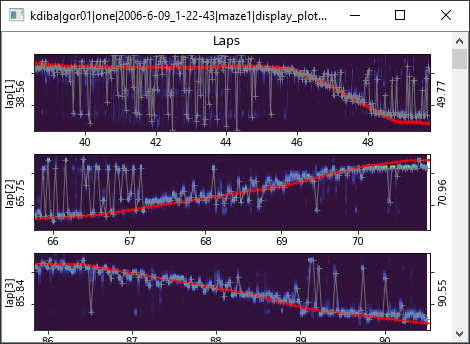
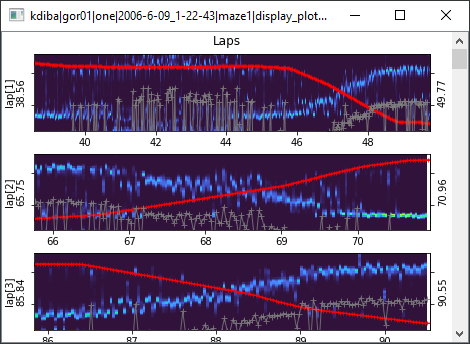

2D is left, 1D is right. Both for 'maze1' so it's not a re-binning issue.

In [ ]:
# Let $x$ be the position
#
# https://notesonai.com/KL+Divergence
# https://observablehq.com/@stwind/forward-and-reverse-kl-divergences
# https://notesonai.com/Maximum+Likelihood+Estimation
#
# Alternative Measures:
#     https://notesonai.com/Jensen%E2%80%93Shannon+Divergence - overcomes becoming infinity when the distributions don't overlap
#
# https://stats.stackexchange.com/questions/188903/intuition-on-the-kullback-leibler-kl-divergence
# https://blogs.rstudio.com/ai/posts/2020-02-19-kl-divergence/
# https://www.linkedin.com/pulse/kl-divergence-some-interesting-facts-niraj-kumar
#
# - [ ] Try Wasserstein distance: https://stats.stackexchange.com/questions/351947/whats-the-maximum-value-of-kullback-leibler-kl-divergence/352008#352008
#

# 🔝 2022-12-21 - For Tomorrow
- [ ] Got decoded replays for each respective epoch, but now need to decode the opposite epoch's replays to see how much better/worse they are. 
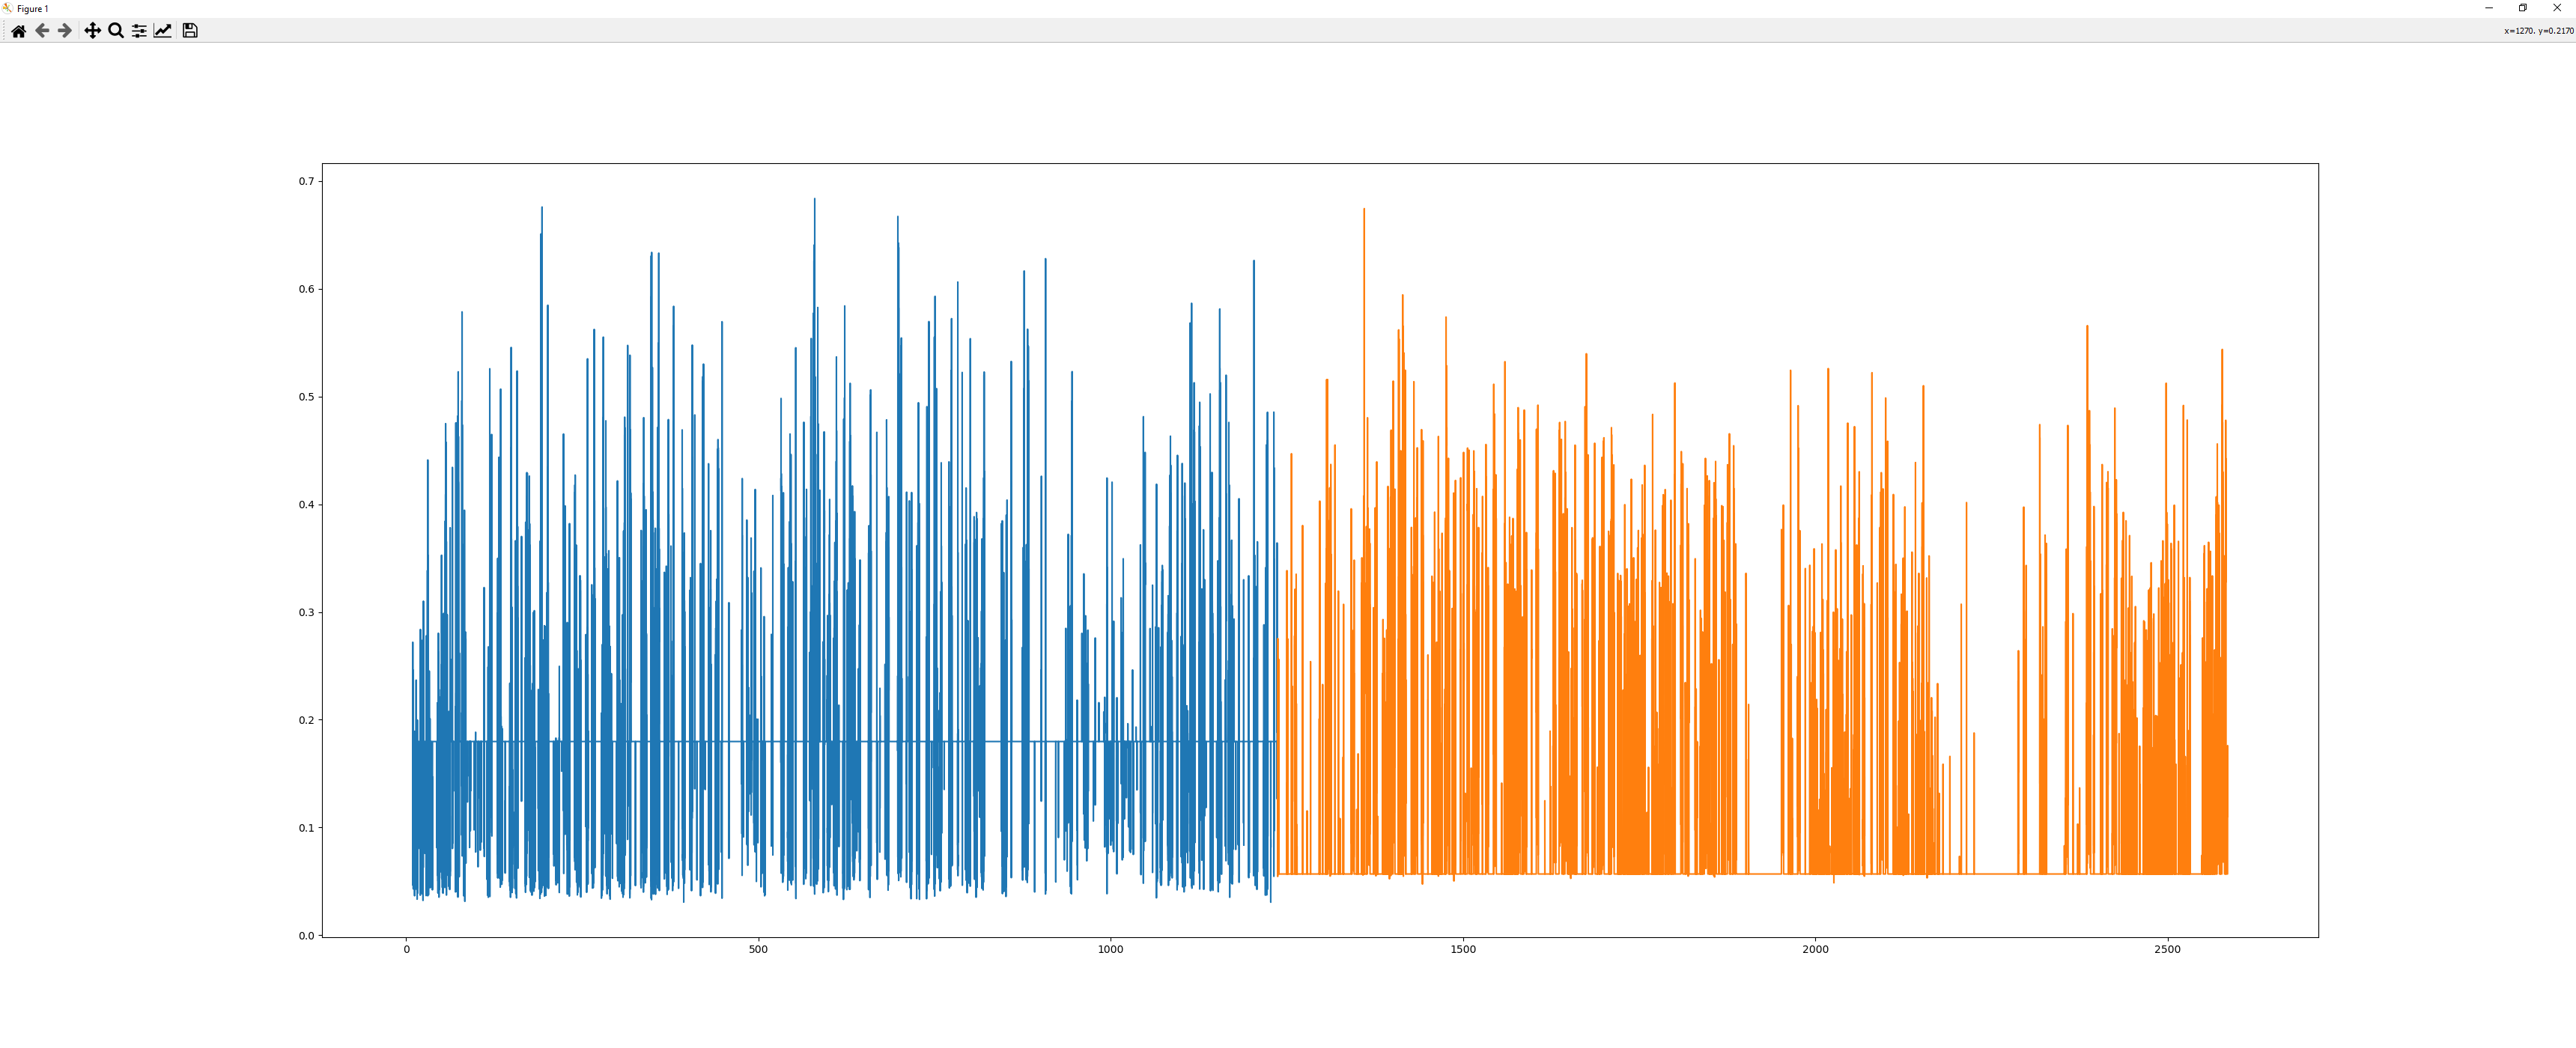

## we need to finish DA computations for DA other epoch. DECODE ON FUTURE MAYNE.

In [ ]:
from PendingNotebookCode import find_epoch_names

long_epoch_name, short_epoch_name, global_epoch_name = find_epoch_names(curr_active_pipeline)
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_replay_df, short_replay_df, global_replay_df = [a_session.replay.epochs.get_non_overlapping_df(debug_print=True).epochs.get_epochs_longer_than(decoding_time_bin_size*2.0, debug_print=True) for a_session in [long_session, short_session, global_session]]

In [ ]:
## Decode on the replays of the opposite epoch:
long_decoding_of_short_epochs_results = long_one_step_decoder_1D.decode_specific_epochs(spikes_df=global_pf1D.filtered_spikes_df, filter_epochs=short_replay_df, decoding_time_bin_size=decoding_time_bin_size)
short_decoding_of_long_epochs_results = short_one_step_decoder_1D.decode_specific_epochs(spikes_df=global_pf1D.filtered_spikes_df, filter_epochs=long_replay_df, decoding_time_bin_size=decoding_time_bin_size)
## Decode on congruent epoch:
long_decoding_of_long_epochs_results = long_one_step_decoder_1D.decode_specific_epochs(spikes_df=global_pf1D.filtered_spikes_df, filter_epochs=long_replay_df, decoding_time_bin_size=decoding_time_bin_size)
short_decoding_of_short_epochs_results = short_one_step_decoder_1D.decode_specific_epochs(spikes_df=global_pf1D.filtered_spikes_df, filter_epochs=short_replay_df, decoding_time_bin_size=decoding_time_bin_size)

In [ ]:
from PendingNotebookCode import _compute_epoch_posterior_confidences
## Opposite:
long_decoding_of_short_epochs_results = _compute_epoch_posterior_confidences(long_decoding_of_short_epochs_results)
short_decoding_of_long_epochs_results = _compute_epoch_posterior_confidences(short_decoding_of_long_epochs_results)
## Congruent:
long_decoding_of_long_epochs_results = _compute_epoch_posterior_confidences(long_decoding_of_long_epochs_results)
short_decoding_of_short_epochs_results = _compute_epoch_posterior_confidences(short_decoding_of_short_epochs_results)

In [ ]:
# Self (long-long and short-short) confidence calculations:
# These posteriors are decoded over the entire epoch time, not just during replays:
# also: reciprocal measure: `posterior_uncertainty_measure = 1.0/posterior_uncertainty_measure` so by dividing by this value gives you a value in the range (+Inf, 1.0)
short_posterior_uncertainty_measure = np.max(short_one_step_decoder_1D.p_x_given_n, axis=0) # each value will be between (0.0, 1.0]
assert short_posterior_uncertainty_measure.shape == (short_one_step_decoder_1D.num_time_windows, ), f"{short_posterior_uncertainty_measure.shape = } must be of shape {(short_one_step_decoder_1D.num_time_windows, ) = }"
long_posterior_uncertainty_measure = np.max(long_one_step_decoder_1D.p_x_given_n, axis=0) # each value will be between (0.0, 1.0]
assert long_posterior_uncertainty_measure.shape == (long_one_step_decoder_1D.num_time_windows, ), f"{long_posterior_uncertainty_measure.shape = } must be of shape {(long_one_step_decoder_1D.num_time_windows, ) = }"

In [ ]:
# Set the overflow property to scroll
long_replay_df.style.set_properties(overflow='scroll', max_height='200px')

In [ ]:
np.min(short_posterior_uncertainty_measure) # 0.18...

In [ ]:
np.median(short_posterior_uncertainty_measure)

In [ ]:
np.max(short_posterior_uncertainty_measure)

In [ ]:
## https://github.com/ydataai/pandas-profiling
# profile = ProfileReport(long_replay_df, title="Pandas Profiling Report") ## try out the new profiler
# profile.to_notebook_iframe()
# don't like this one.

In [ ]:
# also have https://github.com/fbdesignpro/sweetviz to try

In [ ]:
display(long_replay_df)

In [ ]:
import dtale # https://github.com/man-group/dtale

In [ ]:
# Assigning a reference to a running D-Tale process.
d = dtale.show(long_one_step_decoder_1D.p_x_given_n, notebook=True)

In [ ]:
long_one_step_decoder_1D_df = pd.DataFrame(dict(time_window_centers=long_one_step_decoder_1D.time_window_centers, p_x_given_n=long_one_step_decoder_1D.p_x_given_n))
long_one_step_decoder_1D_df

In [ ]:
long_one_step_decoder_1D.p_x_given_n.shape

In [ ]:
# Using Python's `webbrowser` package it will try and open your server's default browser to this process.
d.open_browser()

In [ ]:
# Accessing data associated with D-Tale process.
# tmp = d.data.copy()
# tmp['d'] = 4

# Altering data associated with D-Tale process
# FYI: this will clear any front-end settings you have at the time for this process (filter, sorts, formatting)
d.data = long_one_step_decoder_1D.p_x_given_n

# Shutting down D-Tale process
d.kill()

In [ ]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

### Old entire posterior decoding for same:
# ax.plot(long_one_step_decoder_1D.active_time_window_centers, long_posterior_uncertainty_measure, linestyle='', marker='o',  markersize=2, label='long') # , color='k'
# ax.plot(short_one_step_decoder_1D.active_time_window_centers, short_posterior_uncertainty_measure, linestyle='', marker='o',  markersize=2, label='short')

## Plot Congruent Decodings:
ax.plot(np.concatenate(long_decoding_of_long_epochs_results.combined_plottables_x), np.concatenate(long_decoding_of_long_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='long_decoding_of_long')
ax.plot(np.concatenate(short_decoding_of_short_epochs_results.combined_plottables_x), np.concatenate(short_decoding_of_short_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='short_decoding_of_short') 
# Plot Oppposite Decodings:
ax.plot(np.concatenate(long_decoding_of_short_epochs_results.combined_plottables_x), np.concatenate(long_decoding_of_short_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='long_decoding_of_short')
ax.plot(np.concatenate(short_decoding_of_long_epochs_results.combined_plottables_x), np.concatenate(short_decoding_of_long_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='short_decoding_of_long') 

plt.legend()
plt.title('Decoding Maximum Posterior Confidence')
plt.xlabel('Time [sec]')
plt.ylabel('Maximum Confidence')

In [ ]:
# custom_2D_decoder_container.ax

def _temp_most_likely_position_decoder_plot_sync_window(start_t, end_t):
    global ax
    with plt.ion():
        ax.set_xlim(start_t, end_t)    
        plt.draw()

ax.set_xlim(active_2d_plot.spikes_window.active_window_start_time, active_2d_plot.spikes_window.active_window_end_time)

sync_connection = active_2d_plot.window_scrolled.connect(_temp_most_likely_position_decoder_plot_sync_window) # connect the window_scrolled event to the _on_window_updated function

In [ ]:
ax.plot(np.concatenate(long_decoding_of_long_epochs_results.combined_plottables_x), np.concatenate(long_decoding_of_long_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='long_decoding_of_long')
ax.plot(np.concatenate(short_decoding_of_short_epochs_results.combined_plottables_x), np.concatenate(short_decoding_of_short_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='short_decoding_of_short') 
# Plot Oppposite Decodings:
ax.plot(np.concatenate(long_decoding_of_short_epochs_results.combined_plottables_x), np.concatenate(long_decoding_of_short_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='long_decoding_of_short')
ax.plot(np.concatenate(short_decoding_of_long_epochs_results.combined_plottables_x), np.concatenate(short_decoding_of_long_epochs_results.combined_plottables_y), linestyle='', marker='o',  markersize=2, label='short_decoding_of_long')
widget.draw()

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget()

# Dataframe holds each epoch and the decoding confidence for each decoder

In [ ]:
long_decoding_of_long_epochs_results

# Custom Decoder Plotting 2022-12-23:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions

In [ ]:
widget, fig, ax = active_2d_plot.add_new_matplotlib_render_plot_widget(name='CustomDecoder')

In [ ]:
## plot the `post_update_times`, and `flat_relative_entropy_results`
_temp_out = ax.plot(post_update_times, flat_relative_entropy_results)

# Perform Initial (one-time) update from source -> controlled:
# This syncs the new widget up to the full data window (the entire session), not the active window:
widget.on_window_changed(active_2d_plot.spikes_window.total_data_start_time, active_2d_plot.spikes_window.total_data_end_time)
widget.draw()

In [ ]:
# curr_widget, curr_fig, curr_ax = active_2d_plot.find_matplotlib_render_plot_widget('CustomDecoder')
widget, fig, ax = active_2d_plot.find_matplotlib_render_plot_widget('CustomDecoder')

In [ ]:
## Build the custom decoder:
pho_custom_decoder = long_one_step_decoder_1D
marginal_posterior_x = pho_custom_decoder.marginal.x.p_x_given_n

In [ ]:
curr_fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                        posterior=marginal_posterior_x,
                                                        active_most_likely_positions_1D=pho_custom_decoder.marginal.x.most_likely_positions_1D,
                                                        enable_flat_line_drawing=False, debug_print=False, ax=curr_ax)

In [ ]:
widget.draw()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
active_2d_plot.sync_matplotlib_render_plot_widget('CustomDecoder', sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA)

In [ ]:
_test_connection = active_2d_plot.sync_matplotlib_render_plot_widget('CustomDecoder', sync_mode=SynchronizedPlotMode.TO_WINDOW)
_test_connection

In [ ]:
active_2d_plot.ui.matplotlib_view_widgets

In [ ]:
curr_ax.get_xlim()

In [ ]:
np.save('marginal_posterior_x.npy', marginal_posterior_x)

In [ ]:
marginal_posterior_x

In [ ]:
from pandas_profiling import ProfileReport

# 🔝✳️ 2023-01-19 - "ANALYSIS 1/3" - Replay Fr vs. Lap Fr.

Upon review it looks like much of this is very similar to `compute_evening_morning_parition` and `FiringRateActivitySource`

2023-01-24 - I think `compute_evening_morning_parition` would be great to have across laps in addition to replays. It could pretty easily be epoch general so long as the epochs don't overlap.

❓❗❇️🔜👁️‍🗨️ 2023-01-24 - Do we want to include replays or laps where a unit isn't active at all in that cell's firing rate average? These points would drag down the average rather quickly and could reflect the animal not visiting that cell's place instead of some property of the cell itself.

# Other experimentation:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, session_context_to_relative_path

figures_parent_out_path = create_daily_programmatic_display_function_testing_folder_if_needed()
active_session_figures_out_path = session_context_to_relative_path(figures_parent_out_path, active_identifying_session_ctx)
print(f'curr_session_parent_out_path: {active_session_figures_out_path}')
active_session_figures_out_path.mkdir(parents=True, exist_ok=True) # make folder if needed

active_session_figures_out_path.joinpath()

In [ ]:
def build_labels_if_empty(df):
    print(f"df: {df}")
    if np.alltrue([(str(a_lbl)=='') for a_lbl in df['label']]):
        df['label'] = [str(an_idx) for an_idx in df.index] # regular str label
        # df = df.reset_index(drop=True) # do we need this for some reason?
        df['integer_label'] = [int(float(an_idx)) for an_idx in df.index] # integer_label label
        print(f'labels were missing. Adding "label" and "integer_label".')
    else:
        print(f"df['label']: {df['label']}")
    return df

short_session.ripple._df = build_labels_if_empty(short_session.ripple.to_dataframe())

short_session.ripple._df.epochs.get_valid_df()

external_computed_ripple_df['label'] = [str(an_idx) for an_idx in external_computed_ripple_df.index]
external_computed_ripple_df = external_computed_ripple_df.reset_index(drop=True)

long_session.replay

In [ ]:
active_sess = curr_active_pipeline.filtered_sessions['maze']

In [ ]:
# perform_compute_estimated_replay_epochs
out = active_sess.perform_compute_estimated_replay_epochs()
out

In [ ]:
out1 = active_sess.perform_compute_estimated_replay_epochs(min_epoch_included_duration=0.06, max_epoch_included_duration=0.600, maximum_speed_thresh=2.0)
out1

In [ ]:
out2 = active_sess.perform_compute_estimated_replay_epochs(min_epoch_included_duration=None, max_epoch_included_duration=None, maximum_speed_thresh=2.0)
out2

In [ ]:
out3 = active_sess.perform_compute_estimated_replay_epochs(min_epoch_included_duration=0.1, maximum_speed_thresh=2.0)
out3

# Adding custom rendered intervals easily to 2D plot

In [ ]:
from neuropy.core import Epoch
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, SessionEpochs2DRenderTimeEpochs, PBE_2DRenderTimeEpochs, Laps2DRenderTimeEpochs, Replays_2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import NewRipples_2DRenderTimeEpochs
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource

# new_PBEs_interval_datasource = Specific2DRenderTimeEpochsHelper.build_PBEs_render_time_epochs_datasource(curr_sess=sess, series_vertical_offset=(max_series_top+1.0), series_height=3.0) # new_PBEs_interval_datasource

#### Getting the existing `Spike3DRasterWindowWidget`

In [ ]:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)
assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
spike_raster_window = found_spike_raster_windows[0]
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
%pdb off
# out2 is an Epoch object
new_replay_epochs_intervals_datasource = IntervalsDatasource.init_from_epoch_object(out2, NewRipples_2DRenderTimeEpochs.build_epochs_dataframe_formatter(), datasource_name='replays_out2')

In [ ]:
# %pdb on
active_2d_plot.add_rendered_intervals(new_replay_epochs_intervals_datasource, name='replays_out2', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=False)

In [ ]:
type(new_replay_epochs_intervals_datasource)

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.Testing.EpochsSelectionWidget import EpochsWindow
window = EpochsWindow()
window.show()

window.add_epoch('replays_out2')

window.add_epoch('replays_out3')

In [ ]:
# curr_active_pipeline.plot._display_plot_decoded_epoch_slices

In [ ]:
_temp_out = curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_config_name, filter_epochs='laps', debug_test_max_num_slices=16)

In [ ]:
# curr_active_pipeline.display(display_function='
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps', 'AddTimeIntervals.Session.Epochs']
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()    

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.EpochRenderingMixin import EpochRenderingMixin
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, inline_mkColor

In [ ]:
named_interval_epochs_dict = dict(zip(['replays0', 'replays1', 'replays2', 'replays3'], [out, out1, out2, out3]))
interval_datasources_dict = {k:General2DRenderTimeEpochs.build_render_time_epochs_datasource(active_epochs_obj=v) for k, v in named_interval_epochs_dict.items()}
out_graphics = {k:active_2d_plot.add_rendered_intervals(v, name=k) for k, v in interval_datasources_dict.items()}

In [ ]:
high_speed_epochs_ds = General2DRenderTimeEpochs.build_render_time_epochs_datasource(active_epochs_obj=high_speed_epochs)
active_2d_plot.add_rendered_intervals(high_speed_epochs_ds, name='high_speed')

low_speed_epochs_ds = General2DRenderTimeEpochs.build_render_time_epochs_datasource(active_epochs_obj=low_speed_epochs)
active_2d_plot.add_rendered_intervals(low_speed_epochs_ds, name='low_speed')

epochs_update_dict = {
    'high_speed':dict(y_location=-10.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('red', 0.5)),
    'low_speed':dict(y_location=-2.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('pink', 0.5)),
}
active_2d_plot.update_rendered_intervals_visualization_properties(epochs_update_dict)

In [ ]:
interval_info = active_2d_plot.list_all_rendered_intervals()
interval_info

In [ ]:
# desired_interval_height_ratios = [2.0, 2.0, 1.0, 0.1, 1.0, 1.0, 1.0] # ratio of heights to each interval
rendered_interval_keys = list(interval_info.keys())
desired_interval_height_ratios = [1.0] * len(interval_info) # ratio of heights to each interval
required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout(desired_interval_height_ratios, epoch_render_stack_height=80.0, interval_stack_location='below')
stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(rendered_interval_keys, required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
active_2d_plot.update_rendered_intervals_visualization_properties(stacked_epoch_layout_dict)

# 2023-02-15 - Test and fix `filter_epochs_by_speed` - I think the output is inverted

In [ ]:
from neuropy.utils.efficient_interval_search import _find_intervals_above_speed
from neuropy.utils.efficient_interval_search import _convert_start_end_tuples_list_to_PortionInterval, convert_PortionInterval_to_Epoch_obj

a_session = curr_active_pipeline.filtered_sessions['maze']
speed_thresh = 10.0
speed_df = a_session.position.to_dataframe()
start_end_tuples_interval_list = _find_intervals_above_speed(speed_df, speed_thresh, is_interpolated=True)
above_speed_threshold_intervals = _convert_start_end_tuples_list_to_PortionInterval(start_end_tuples_interval_list)
print(f'len(above_speed_threshold_intervals): {len(above_speed_threshold_intervals)}')
# find the intervals below the threshold speed by taking the complement:
below_speed_threshold_intervals = above_speed_threshold_intervals.complement()

high_speed_epochs = convert_PortionInterval_to_Epoch_obj(above_speed_threshold_intervals)
low_speed_epochs = convert_PortionInterval_to_Epoch_obj(below_speed_threshold_intervals)

In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.EpochRenderingMixin import EpochRenderingMixin
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, inline_mkColor

## Add to SpikeRaster2D:
high_speed_epochs_ds = General2DRenderTimeEpochs.build_render_time_epochs_datasource(active_epochs_obj=high_speed_epochs)
active_2d_plot.add_rendered_intervals(high_speed_epochs_ds, name='high_speed')

low_speed_epochs_ds = General2DRenderTimeEpochs.build_render_time_epochs_datasource(active_epochs_obj=low_speed_epochs)
active_2d_plot.add_rendered_intervals(low_speed_epochs_ds, name='low_speed')

epochs_update_dict = {
    'high_speed':dict(y_location=-10.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('red', 0.9)),
    'low_speed':dict(y_location=-2.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('pink', 0.9)),
}
active_2d_plot.update_rendered_intervals_visualization_properties(epochs_update_dict)

In [ ]:
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

# Hide all spikes entirely to focus on the epochs:
active_2d_plot.update_spike_emphasis(new_emphasis_state=SpikeEmphasisState.Hidden)

In [ ]:
curr_replays = a_session.
curr_replays, above_speed_threshold_intervals, below_speed_threshold_intervals = filter_epochs_by_speed(a_session.position.to_dataframe(), curr_replays, speed_thresh=maximum_speed_thresh, debug_print=debug_print)

In [ ]:
pos_df = a_session.position.compute_higher_order_derivatives()
pos_df = a_session.position.compute_smoothed_position_info()
pos_df

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
pos_df['speed'].plot()
plt.show()

In [ ]:
np.max(a_session.position.velocity_x)

In [ ]:
np.nanmax(pos_df.velocity_x_smooth)

In [ ]:
np.nanmin(pos_df.velocity_x_smooth)

In [ ]:
out_widget, embedded_fig, embedded_ax = active_2d_plot.add_new_matplotlib_render_plot_widget(row=1, col=0, name='matplotlib_view_widget')
pos_df[['t', 'x', 'lin_pos', 'speed', 'velocity_x', 'x_smooth', 'velocity_x_smooth']].plot(x='t', ax=embedded_ax, subplots=[('x', 'x_smooth', 'lin_pos'), ('speed', 'velocity_x', 'velocity_x_smooth')])
active_2d_plot.sync_matplotlib_render_plot_widget(identifier='matplotlib_view_widget')

In [ ]:
from matplotlib import ticker
for ax in active_2d_plot.ui.matplotlib_view_widgets['matplotlib_view_widget'].axes:
    # Display grid lines
    ax.grid(False)
    # Set the y-axis ticks and grid lines
    ax.yaxis.set_ticks_position('left')  # Display ticks on the left side only
    ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax.yaxis.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)  # Display major grid lines
    # yticks = [0, 2, 4, 6, 8, 10]
    y_bottom, y_top = ax.get_ybound()
    # yticks = np.arange(y_bottom, y_top+1, 2)
    yticks = np.linspace(y_bottom, y_top, num=10)
    ax.set_yticks(yticks)
    
out_widget.draw()

In [ ]:
# Add cursor because matplotlib isn't showing values in any meaningful way:
import matplotlib.pyplot as plt
import mplcursors

# Add value trace to axes
mplcursors.cursor(active_2d_plot.ui.matplotlib_view_widgets['matplotlib_view_widget'].axes, hover=True)

In [ ]:
out_widget.draw()